# Web Search LLMs - ChatOpenAI, Perplexity

In [ ]:
from langchain_core.prompts import PromptTemplate
from langchain.schema import HumanMessage, SystemMessage
from langchain_core.output_parsers import MarkdownListOutputParser
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_community.chat_models import ChatPerplexity
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from typing import List
from pprint import pprint
import os
import getpass
import csv

In [43]:
if not os.getenv("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

In [3]:
if not os.getenv("PERPLEXITY_API_KEY"):
    os.environ["PERPLEXITY_API_KEY"] = getpass.getpass("Enter your Perplexity API key: ")

In [ ]:
if not os.getenv("HUGGINGFACEHUB_API_TOKEN"):
    os.environ["HUGGINGFACEHUB_API_TOKEN"] = getpass.getpass("Enter your Huggingface token: ")

In [44]:
#for structuring product data which can be integrated into a LangChain workflow
class Product(BaseModel):
    brand: str = Field(description="the brand of the specific product, e.g. nestle")
    long_title: str = Field(description="the long name of the specific product, e.g. nescafe classic instant coffee")
    short_title: str = Field(description="the short name of the specific product, e.g. nescafe classic")
    description: str = Field(description="one sentence that best describe the product")
    rank: int = Field(description="the integer rank of this product out of all products")
    urls: List[str] = Field(description="""Return at least 5 URLs from blog posts, review articles, 
    or editorial roundups where this product is recommended or positively mentioned. Each source 
    must include a reason, explanation, or context for the recommendation. Only include content-based 
    sources that explain why the product is being recommended.""")

class ProductSearchResult(BaseModel):
    products: List[Product] = Field("A list of product as the search result.")

In [ ]:
output_parser = JsonOutputParser(pydantic_object=ProductSearchResult)
print(output_parser.get_format_instructions())

In [46]:
def generate_ranking(model, prompt, verbose=False, **variables):
    # JsonOutputParser parse the model's output into a ProductSearchResult schema
    output_parser = JsonOutputParser(pydantic_object=ProductSearchResult)
    # Create PromptTemplate
    prompt_template = PromptTemplate(
        template=prompt,
        input_variables=variables.keys(),
        partial_variables={"format_instruction": output_parser.get_format_instructions()},
    )
    # Fills the placeholders in the prompt template with the provided variables
    constructed_prompt = prompt_template.invoke(variables)
    # Generates a response
    ai_output = model.invoke(constructed_prompt)

    '''If the output is valid JSON and matches the ProductSearchResult schema, 
    it is converted into a Pydantic object. If parsing fails, parsed_output is set to None'''
    try:
        parsed_output = output_parser.invoke(ai_output)
    except:
        parsed_output = None  # could not be parsed
    if verbose:
        print("Prompt:")
        pprint(constructed_prompt)
        print("\nAI Output:")
        pprint(ai_output)
        print("\nParsed Output:")
        pprint(parsed_output)
    return constructed_prompt.text, ai_output.content, parsed_output
#The final prompt that was sent to the model


In [47]:
async def generate_ranking_async(model, prompt, **variables):
    # JsonOutputParser parse the model's output into a ProductSearchResult schema
    output_parser = JsonOutputParser(pydantic_object=ProductSearchResult)
    # Create PromptTemplate
    prompt_template = PromptTemplate(
        template=prompt,
        input_variables=variables.keys(),
        partial_variables={"format_instruction": output_parser.get_format_instructions()},
    )
    # Fills the placeholders in the prompt template with the provided variables
    constructed_prompt = prompt_template.invoke(variables)
    # Generates a response
    ai_output = await model.ainvoke(constructed_prompt)

    '''If the output is valid JSON and matches the ProductSearchResult schema, 
    it is converted into a Pydantic object. If parsing fails, parsed_output is set to None'''
    try:
        parsed_output = output_parser.invoke(ai_output)
    except:
        parsed_output = None  # could not be parsed
    return constructed_prompt.text, ai_output.content, parsed_output
#The final prompt that was sent to the model


In [48]:
model_test = ChatOpenAI(model_name = "gpt-4o-search-preview")
c,a,p = generate_ranking(model_test, 'Top 10 recommended Instant Coffee in Canada. {format_instruction}')
p

{'products': [{'brand': 'Tim Hortons',
   'long_title': 'Tim Hortons Medium Roast Instant Coffee, 100% Colombian, 300g Jar',
   'short_title': 'Tim Hortons Medium Roast Instant Coffee',
   'description': 'A well-balanced medium roast made with 100% Colombian Arabica beans, offering a smooth finish.',
   'rank': 1,
   'urls': ['https://cornercoffeestore.com/best-instant-coffees-canada/',
    'https://www.bestproductscanada.com/instant-coffee',
    'https://www.amazon.ca/Best-Sellers-Instant-Coffee/zgbs/grocery/7351106011']},
  {'brand': 'Maxwell House',
   'long_title': 'Maxwell House Original Roast Instant Coffee, 150g Jar',
   'short_title': 'Maxwell House Original Roast Instant Coffee',
   'description': 'A dependable medium roast offering a classic coffee taste, widely available and affordable.',
   'rank': 2,
   'urls': ['https://cornercoffeestore.com/best-instant-coffees-canada/',
    'https://www.bestproductscanada.com/instant-coffee',
    'https://www.amazon.ca/Best-Sellers-Inst

In [56]:
import re
from fuzzywuzzy import fuzz
from unidecode import unidecode
def normalize_name(name):
    """
    Normalize the text by:
      - Converting to lowercase.
      - Transliterate Unicode to ASCII.
      - Removing extra spaces.
      - Removing punctuation.
    """
    if not isinstance(name, str):
        return ""
    name = name.lower()
    name = unidecode(name)
    name = re.sub(r'\s+', ' ', name)
    name = re.sub(r'[^\w\s]', '', name)
    return name.strip()

In [57]:
def add_to_results(result, model_name, ranking, threshold=90):
    """
    Integrates fuzzy matching into grouping.

    For each product in the ranking list:
      1. Normalize its 'brand' and 'long_title'.
      2. Iterate over existing grouped entries in 'result' that share the same normalized brand.
      3. Compare the normalized names using fuzzy matching.
         - If a similarity score >= threshold is found, the product is considered duplicate.
         - Otherwise, create a new group.
      4. Assign the product's rank to the corresponding group under the provided model name.

    :param result: Dictionary where the keys are a combination of brand and product name.
    :param model_name: Key to store the product's rank in the group.
    :param ranking: List of product dictionaries.
    :param threshold: Similarity threshold for fuzzy matching (0-100).
    """
    for product in ranking:
        # Normalize the product's brand and long title.
        norm_brand = normalize_name(product["brand"])
        norm_name = normalize_name(product["long_title"])
        found_key = None
        
        for key, existing in result.items():
            existing_norm_brand = normalize_name(existing["brand"])
            if existing_norm_brand == norm_brand:
                existing_norm_name = normalize_name(existing["long_title"])
                similarity = fuzz.token_sort_ratio(norm_name, existing_norm_name)
                if similarity >= threshold:
                    found_key = key
                    break
                    
        # If no similar product exists, create a new group.
        if found_key is None:
            new_key = f"{norm_brand}_{norm_name}"
            result[new_key] = dict(product)
            # Remove the original 'rank' as it will be replaced by model-specific ranking.
            del result[new_key]["rank"]
            found_key = new_key
        
        # Add or update the model-specific ranking.
        result[found_key][model_name] = product["rank"]

In [58]:
def create_model(vendor_name, model_name, temperature=0, location=None):
    # Temperature controls the randomness of the model's output. 
    # Higher values make the output more random
    
    # Initialize the appropriate model
    if vendor_name == "OpenAI":
        if not os.getenv("OPENAI_API_KEY"):
            raise Exception("Please login to openai!")
        user_location = {
            "type": "approximate",
            "approximate": {
                "country": "CA",
            # "city": "Toronto",
            # "region": "Ontario",
            }
        }
        model = ChatOpenAI(
            model=model_name, 
            api_key=os.environ["OPENAI_API_KEY"], 
            # temperature=temperature,
            model_kwargs={
                "web_search_options": {
                    "user_location": user_location
                }
            }
        )
    elif vendor_name == "Huggingface":
        if not os.getenv("HUGGINGFACEHUB_API_TOKEN"):
            raise Exception("Please login to huggingface!")
        llm = HuggingFaceEndpoint(
            repo_id=model_name,
            temperature=temperature,
            huggingfacehub_api_token=os.environ["HUGGINGFACEHUB_API_TOKEN"]
        )
        model = ChatHuggingFace(llm=llm)
    elif vendor_name == "Perplexity":
        if not os.getenv("PERPLEXITY_API_KEY"):
            raise Exception("Please login to perlexity!")
        model = ChatPerplexity(
            model=model_name, 
            api_key=os.environ["PERPLEXITY_API_KEY"], 
            temperature=temperature
        )
    else:
        raise Exception("Unknown model vendor")
    return f"{model_name}_temp{temperature}", model


In [12]:
_, model_test = create_model("Perplexity", "sonar-pro", temperature=0)
c,a,p = generate_ranking(model_test, 'List the top 10 instant coffee brands. {format_instruction}')

/var/folders/xk/pnnqj1ks1ns9b3v_49kznrp80000gn/T/ipykernel_60659/1428112680.py:26: LangChainDeprecationWarning: The class `ChatPerplexity` was deprecated in LangChain 0.3.21 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-perplexity package and should be used instead. To use it run `pip install -U :class:`~langchain-perplexity` and import as `from :class:`~langchain_perplexity import ChatPerplexity``.
  model = ChatPerplexity(


In [59]:
import itertools
import json
import tqdm
import datetime

def generate_all_rankings(
    products,
    retailers,
    model_configs,
    prompts,
    past_results={},
    amount="ten",
    verbose=False,
    num_try = 2
):
    # Iterate over all combinations
    outputs = []
    results = dict(past_results)
    models = [create_model(*config) for config in model_configs]
    try_indices = list(range(num_try))
    configs = list(itertools.product(try_indices, products, retailers, prompts, models))
    for i, (try_index, product, retail, prompt, (model_name, model)) in enumerate(configs):
        try:
            # Call the generate_ranking function
            constructed_prompt, ai_output, ranking = generate_ranking(
                model,
                prompt,
                verbose=verbose,
                product=product,
                retail=retail,
                amount=amount,
            )
            outputs.append({
                "product": product,
                "retail": retail,
                "amount": amount,
                "constructed_prompt": constructed_prompt, 
                "model_name": f"{model_name}_round{try_index}",
                "ai_output": ai_output,
                "ranking": ranking,
            })
            if ranking is not None:
                product_ranking = ranking["products"]
                for item in product_ranking:
                    item["category"] = product
                    item["retail"] = retail
                    item["query"] = constructed_prompt #TODO
                    item["timestamp"] = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") #TODO
                add_to_results(results, f"{model_name}_round{try_index}", product_ranking)
                print(f"{i + 1}/{len(configs)} Successfully generated ranking for {product} at {retail} using {model_name}_round{try_index}")
            else:
                print(f"{i + 1}/{len(configs)} Failed to generate ranking for {product} at {retail} using {model_name}_round{try_index}: {ai_output}")
        except Exception as e:
            print(f"{i + 1}/{len(configs)} Failed to generate ranking for {product} at {retail} using {model_name}_round{try_index}: {e}")

    # save raw output into a file dump
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"generate_all_rankings_{timestamp}.json"
    with open(filename, "w") as f:
        json.dump(outputs, f, indent=4)
    return results

In [60]:
import itertools
import json
import datetime
import asyncio
import aiohttp

async def generate_all_rankings_async(
    products,
    retailers,
    model_configs,
    prompts,
    past_results={},
    amount="ten",
    verbose=False,
    num_try=2,
    max_requests_per_minute=20  # maximum number of functions to run per minute
):
    async def _generate_one_ranking_async(try_index, product, retail, prompt, model_name, model):
        """
        Return (output_append, add_to_results_params, message)
        """
        try:
            # Call the generate_ranking_async function (assumed to be defined elsewhere)
            constructed_prompt, ai_output, ranking = await generate_ranking_async(
                model,
                prompt,
                verbose=verbose,
                product=product,
                retail=retail,
                amount=amount,
            )
            output_append = {
                "product": product,
                "retail": retail,
                "amount": amount,
                "constructed_prompt": constructed_prompt, 
                "model_name": f"{model_name}_round{try_index}",
                "ai_output": ai_output,
                "ranking": ranking,
            }
            if ranking is not None:
                product_ranking = ranking["products"]
                for item in product_ranking:
                    item["category"] = product
                    item["retail"] = retail
                    item["query"] = constructed_prompt #TODO
                    item["timestamp"] = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") #TODO
                add_to_results_params = (f"{model_name}_round{try_index}", product_ranking)
                return output_append, add_to_results_params, (
                    f"Successfully generated ranking for {product} at {retail} using {model_name}_round{try_index}"
                )
            else:
                return output_append, None, (
                    f"Failed to generate ranking for {product} at {retail} using {model_name}_round{try_index}: {ai_output}"
                )
        except Exception as e:
            return None, None, (
                f"Failed to generate ranking for {product} at {retail} using {model_name}_round{try_index}: {e}"
            )
    
    outputs = []
    results = dict(past_results)
    # Create models from configs; assumes create_model is defined elsewhere
    models = [create_model(*config) for config in model_configs]
    try_indices = list(range(num_try))
    # Create all combinations of parameters
    configs = list(itertools.product(try_indices, products, retailers, prompts, models))
    
    # Process configs in batches to throttle API calls per minute
    for i in range(0, len(configs), max_requests_per_minute):
        batch = configs[i:i+max_requests_per_minute]
        start_time = asyncio.get_running_loop().time()  # record start time for the batch
        tasks = []
        for try_index, product, retail, prompt, (model_name, model) in batch:
            task = asyncio.create_task(
                _generate_one_ranking_async(try_index, product, retail, prompt, model_name, model)
            )
            tasks.append(task)
        batch_results = await asyncio.gather(*tasks)
        # Process the results from the batch
        for idx, result in enumerate(batch_results):
            if result is not None:
                output_append, add_to_results_params, message = result
                if output_append is not None:
                    outputs.append(output_append)
                if add_to_results_params is not None:
                    add_to_results(results, *add_to_results_params)
                if message is not None:
                    print(f"{i + idx + 1}/{len(configs)} {message}")
        # Calculate elapsed time; if less than 60 seconds, sleep for the remaining time
        elapsed = asyncio.get_running_loop().time() - start_time
        if elapsed < 60:
            await asyncio.sleep(60 - elapsed)
    
    # Save raw output into a file dump with a timestamped filename
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"generate_all_rankings_{timestamp}.json"
    with open(filename, "w") as f:
        json.dump(outputs, f, indent=4)
    
    return results

In [ ]:
prompts = ["List the top {amount} {product} brands available on {retail}. {format_instruction}",
           "Name the most recommended {amount} {product} brands on {retail}. {format_instruction}",
           "Can you identify the top {amount} {product} brands on {retail}? {format_instruction}"]

products = [
    "Baking Ingredients", 
    "Instant Coffee", 
    "Dog Food", 
    "Cat Food", 
    "Cat Litter"
]
retailers = [
    "Costco", 
    "Amazon", 
    "Target", 
    "Walmart", 
    "Metro"
]
model_configs = [
    ("OpenAI", "gpt-4o", 0.8),
    ("OpenAI", "gpt-4o", 0.2),
    ("Perplexity", "sonar", 0.8),
    ("Perplexity", "sonar", 0.2),
    ("Perplexity", "sonar-pro", 0.8),
    ("Perplexity", "sonar-pro", 0.2),
    ("Huggingface", "meta-llama/Llama-3.1-70B-Instruct"),
    ("Huggingface", "mistralai/Mistral-7B-Instruct-v0.3")

]

# Call the main function
ranking_result = generate_all_rankings(
    products=products,
    retailers=retailers,
    model_configs=model_configs,
    prompts=prompts,
    amount="Ten",
    verbose=False,
    past_results={},
    num_try = 2,
)


In [ ]:
prompts = [
    "Top {amount} recommended {product} in Canada. {format_instruction}"
    "best {amount} {product}. {format_instruction}",
    "List the top {amount} {product} brands available on {retail}. {format_instruction}",
    "Name the most recommended {amount} {product} brands on {retail}. {format_instruction}",
    "Can you identify the top {amount} {product} brands on {retail}? {format_instruction}",
    ]

products = [
            "Baking Ingredients", 
            "Instant Coffee", 
            "Dog Food", 
            "Cat Food", 
            "Cat Litter",
            ]
retailers = [""]
model_configs = [
    ("OpenAI", "gpt-4o-search-preview"),
    ("Perplexity", "sonar-pro", 0.2),
    ]

# Call the main function
ranking_result = await generate_all_rankings_async(
    products=products,
    retailers=retailers,
    model_configs=model_configs,
    prompts=prompts,
    amount="Ten",
    verbose=False,
    past_results={}, #ranking_result
    num_try = 200,
    max_requests_per_minute=20
)

In [42]:
ranking_result.values()

dict_values([{'brand': 'Tim Hortons', 'long_title': 'Tim Hortons Medium Roast Instant Coffee, 100% Colombian, 300g Jar', 'short_title': 'Tim Hortons Medium Roast Instant Coffee', 'description': 'A well-balanced medium roast made with 100% Colombian Arabica beans, offering a smooth finish.', 'urls': ['https://cornercoffeestore.com/best-instant-coffees-canada/', 'https://www.amazon.ca/Best-Sellers-Instant-Coffee/zgbs/grocery/7351106011'], 'category': 'Instant Coffee', 'retail': '', 'query': 'Top Ten recommended Instant Coffee in Canada. The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{

In [ ]:
import pandas as pd
import numpy as np
df_ranking_result = pd.DataFrame(ranking_result.values())
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
df_ranking_result.to_csv(f"df_openai_ranking_results_{timestamp}.csv")
df_ranking_result.to_csv(f"df_sonarpro_ranking_results_{timestamp}.csv")

# Consistency Analysis

In [ ]:
# Load the data uploaded earlier
df = pd.read_csv('df_filtered.csv')

# Identify model columns for each round
round0_cols = [c for c in df.columns if c.endswith('_round0')]
round1_cols = [c for c in df.columns if c.endswith('_round1')]

# Build a mapping of base model names -> their round columns
model_names = {}
for col in round0_cols:
    base = col[:-7]  # strip "_round0"
    model_names.setdefault(base, {})['round0'] = col
for col in round1_cols:
    base = col[:-7]  # strip "_round1"
    model_names.setdefault(base, {})['round1'] = col

records = []
for _, row in df.iterrows():
    consistency_values = {}
    for model, cols in model_names.items():
        if 'round0' in cols and 'round1' in cols:
            r0 = row[cols['round0']]
            r1 = row[cols['round1']]
            if not (pd.isna(r0) or pd.isna(r1)):
                consistency_values[model] = abs(r1 - r0)

    avg_consistency = np.mean(list(consistency_values.values())) if consistency_values else np.nan

    # Bias spread for each round
    r0_values = [row[cols['round0']] for m, cols in model_names.items() if 'round0' in cols and not pd.isna(row[cols['round0']])]
    r1_values = [row[cols['round1']] for m, cols in model_names.items() if 'round1' in cols and not pd.isna(row[cols['round1']])]
    bias_r0 = max(r0_values) - min(r0_values) if r0_values else np.nan
    bias_r1 = max(r1_values) - min(r1_values) if r1_values else np.nan

    record = {
        "Category": row["category"],
        "Product": row["short_title"],
        "Avg Ranking Consistency": avg_consistency,
        "Bias Spread Round0": bias_r0,
        "Bias Spread Round1": bias_r1,
    }
    # Add per‑model consistency if available
    for model, value in consistency_values.items():
        record[f"Consistency {model}"] = value

    records.append(record)

result_df = pd.DataFrame(records)

# Aggregate summary by category
category_summary = (
    result_df.groupby("Category")
    .agg({
        "Avg Ranking Consistency": "mean",
        "Bias Spread Round0": "mean",
        "Bias Spread Round1": "mean",
    })
    .reset_index()
)


category_summary

,Category,Avg Ranking Consistency,Bias Spread Round0,Bias Spread Round1
0,Baking Ingredients,0.411905,0.874384,0.644444
1,Cat Food,0.275377,0.662971,0.241877
2,Cat Litter,0.161088,0.636139,0.229885
3,Dog Food,0.297508,0.842615,0.412955
4,Instant Coffee,0.147989,0.947368,0.300000


In [11]:
result_df[
        ["Category", "Product", "Avg Ranking Consistency", "Bias Spread Round0", "Bias Spread Round1"]
    ]

,Category,Product,Avg Ranking Consistency,Bias Spread Round0,Bias Spread Round1
0,Baking Ingredients,Vanilla Extract,3.0,9.0,3.0
1,Baking Ingredients,Organic Flour,0.5,5.0,6.0
2,Baking Ingredients,All-Purpose Flour,0.0,8.0,3.0
3,Baking Ingredients,Granulated Sugar,3.0,5.0,0.0
4,Baking Ingredients,Chocolate Chips,2.0,5.0,0.0
...,...,...,...,...,...
2073,Cat Litter,PrettyLitter Silica Gel,0.0,0.0,0.0
2074,Cat Litter,Dr. Elsey's Ultra,0.0,0.0,0.0
2075,Cat Litter,Littersolutions Corn,0.0,0.0,0.0
2076,Cat Litter,Petmate Arm & Hammer Eco-Smart Multi-Cat,0.0,0.0,0.0


# Web search results analysis

In [61]:
file_path2 = "OpenAI_web_search_4_21_processed.csv"
df_ranking = pd.read_csv(file_path2)
df_ranking.drop(columns=["brand", "short_title", "urls", "description", "category", "retail", "query", "timestamp"], axis=1)

,Unnamed: 0,long_title,gpt-4o-search-preview_temp0_round1,gpt-4o-search-preview_temp0_round2,gpt-4o-search-preview_temp0_round3,gpt-4o-search-preview_temp0_round4,gpt-4o-search-preview_temp0_round5,gpt-4o-search-preview_temp0_round6,gpt-4o-search-preview_temp0_round7,gpt-4o-search-preview_temp0_round9,...,gpt-4o-search-preview_temp0_round123,gpt-4o-search-preview_temp0_round126,gpt-4o-search-preview_temp0_round135,gpt-4o-search-preview_temp0_round138,gpt-4o-search-preview_temp0_round139,Mention Count,Avg Rank (Skip NaN),Avg Rank (Fill 0),Avg Rank (Fill 11),URLs count
0,0,"Tim Hortons Medium Roast Instant Coffee, 100% ...",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,79,1.00,0.77,3.25,2
1,1,"Maxwell House Original Roast Instant Coffee, 1...",2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,5.0,2.0,2.0,2.0,2.0,102,2.09,2.09,2.09,2
2,2,Starbucks Via Instant True North Blend Blonde ...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,79,3.00,2.32,4.80,2
3,3,"Nescafé Gold Espresso Instant Coffee, 200g",4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,79,4.00,3.10,5.58,2
4,4,"Nescafé Rich Instant Coffee, Dark Roast Coffee...",5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,79,5.00,3.87,6.35,2
5,5,Starbucks Medium Roast Premium Instant Coffee ...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,NaN,NaN,NaN,NaN,NaN,79,6.00,4.65,7.13,2
6,6,VitaCup Perfect Low Acid Instant Coffee Packets,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,6,7.00,0.41,10.76,1
7,7,Mount Hagen Organic Fair Trade Freeze Dried In...,8.0,NaN,NaN,8.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,15,8.00,1.18,10.56,1
8,8,La Republica Organic Decaf Instant Coffee,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5,9.00,0.44,10.90,1
9,9,Alpine Start Premium Instant Coffee,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5,10.00,0.49,10.95,1


In [10]:
import ast

In [11]:
# Group by brand and count total URL appearances per brand
brand_url_counts = df_ranking.groupby('brand')['URLs count'].sum().reset_index()

In [12]:
brand_url_counts

,brand,URLs count
0,Alpine Start,1
1,Douwe Egberts,0
2,Folgers,3
3,Jacobs,0
4,Just Us!,1
5,Kenco,0
6,La Republica,1
7,Lavazza,0
8,Maxwell House,2
9,McCafe,2


In [20]:
brand_url_counts['probability'] = brand_url_counts['URLs count'] / brand_url_counts['URLs count'].sum()
brand_url_counts_sorted = brand_url_counts.sort_values(by='URLs count', ascending=False)

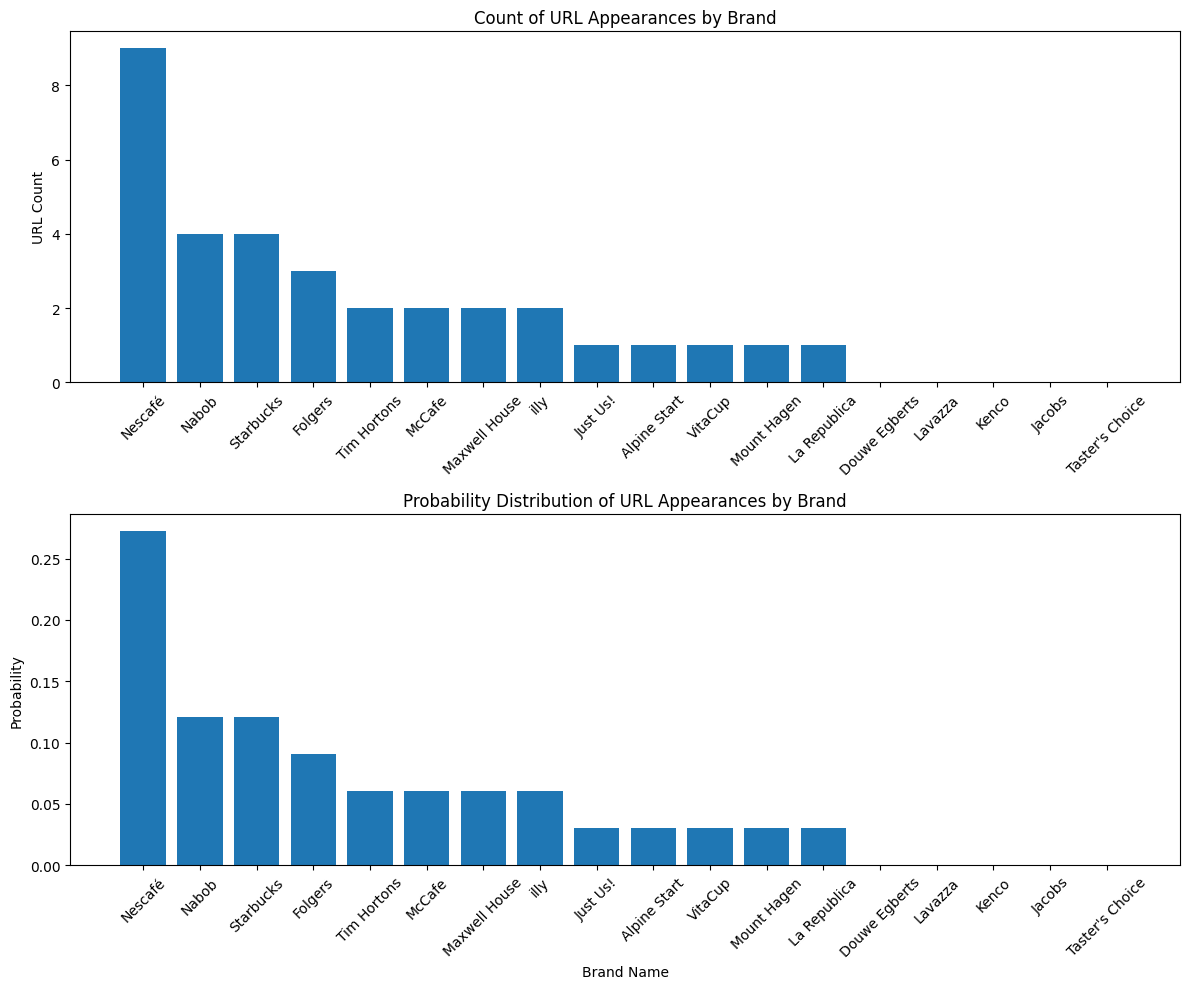

In [21]:
import matplotlib.pyplot as plt
# Plot both: count and probability distributions
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Count plot
axs[0].bar(brand_url_counts_sorted['brand'], brand_url_counts_sorted['URLs count'])
axs[0].set_title('Count of URL Appearances by Brand')
axs[0].set_ylabel('URL Count')
axs[0].tick_params(axis='x', rotation=45)

# Probability distribution plot
axs[1].bar(brand_url_counts_sorted['brand'], brand_url_counts_sorted['probability'])
axs[1].set_title('Probability Distribution of URL Appearances by Brand')
axs[1].set_ylabel('Probability')
axs[1].set_xlabel('Brand Name')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [34]:
# Group by brand and count total URL appearances per brand
brand_counts_openai = df_ranking.groupby('brand')['Mention Count'].sum().reset_index()
brand_counts_openai

,brand,Mention Count
0,Alpine Start,5
1,Douwe Egberts,2
2,Folgers,79
3,Jacobs,2
4,Just Us!,21
5,Kenco,2
6,La Republica,5
7,Lavazza,2
8,Maxwell House,102
9,McCafe,73


In [62]:
brand_counts_openai['probability'] = brand_counts_openai['Mention Count'] / brand_counts_openai['Mention Count'].sum()
brand_counts_openai_sorted = brand_counts_openai.sort_values(by='Mention Count', ascending=False)
brand_counts_openai_sorted

,brand,Mention Count,probability
12,Nescafé,213,0.234581
13,Starbucks,160,0.176211
8,Maxwell House,102,0.112335
2,Folgers,79,0.087004
15,Tim Hortons,79,0.087004
9,McCafe,73,0.080396
17,illy,72,0.079295
11,Nabob,66,0.072687
4,Just Us!,21,0.023128
10,Mount Hagen,17,0.018722


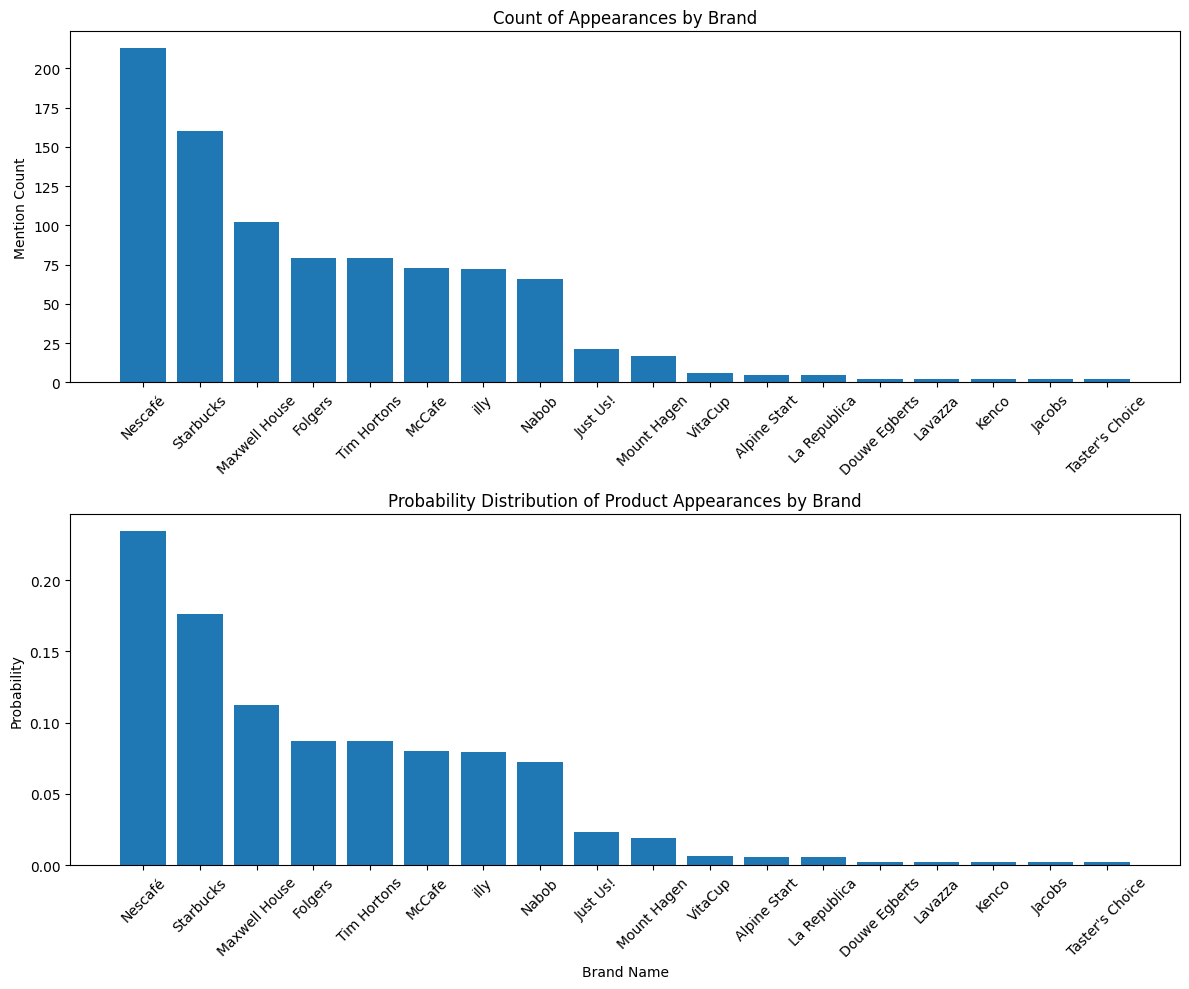

In [66]:
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Count plot
axs[0].bar(brand_counts_openai_sorted['brand'], brand_counts_openai_sorted['Mention Count'])
axs[0].set_title('Count of Appearances by Brand')
axs[0].set_ylabel('Mention Count')
axs[0].tick_params(axis='x', rotation=45)

# Probability distribution plot
axs[1].bar(brand_counts_openai_sorted['brand'], brand_counts_openai_sorted['probability'])
axs[1].set_title('Probability Distribution of Product Appearances by Brand')
axs[1].set_ylabel('Probability')
axs[1].set_xlabel('Brand Name')
axs[1].tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()


/var/folders/xk/pnnqj1ks1ns9b3v_49kznrp80000gn/T/ipykernel_29719/1931621003.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", len(brands))  # Can try "Set3", "Pastel1", etc.


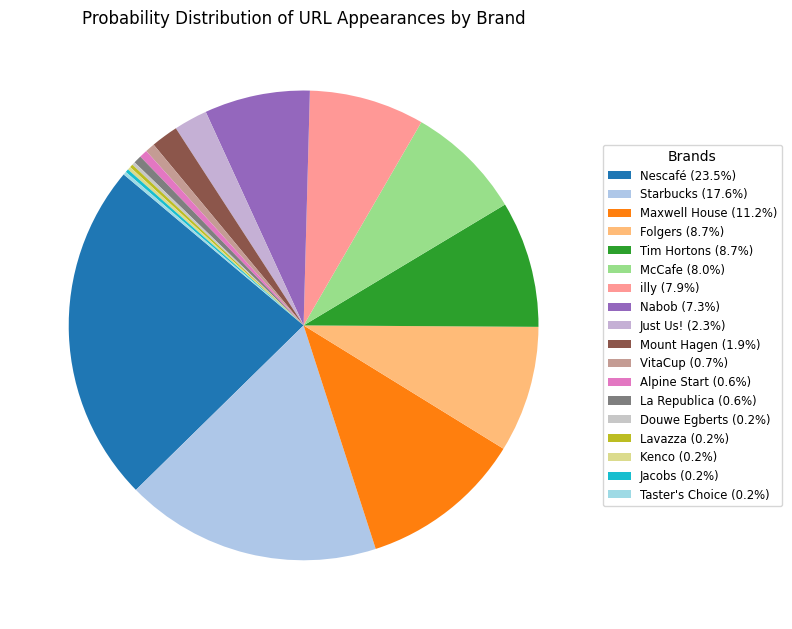

In [70]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Brand names and their probabilities
brands = brand_counts_openai_sorted['brand']
probs = brand_counts_openai_sorted['probability']

# Format percentages
percent_labels = [f"{brand} ({prob*100:.1f}%)" for brand, prob in zip(brands, probs)]

# Generate a color map
cmap = cm.get_cmap("tab20", len(brands))  # Can try "Set3", "Pastel1", etc.
colors = [cmap(i) for i in range(len(brands))]

fig, ax = plt.subplots(figsize=(8, 8))

# Create pie chart with colors only (no labels or percentages on slices)
wedges, _ = ax.pie(
    probs,
    colors=colors,
    startangle=140
)

# Add a legend with percentages
ax.legend(
    wedges,
    percent_labels,
    title="Brands",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize="small"
)

ax.set_title("Probability Distribution of URL Appearances by Brand")
plt.tight_layout()
plt.show()


# Offline Models Visualization

In [4]:
import numpy as np
df = pd.read_csv("df_openai_ranking_results.csv")
brands = df['brand'].unique()
cleaned_brands = sorted([brand.strip() for brand in brands])
print("Unique brands in the dataset:")
cleaned_brands

Unique brands in the dataset:


['9Lives',
 'ACANA',
 'AZO',
 'Acana',
 'Aldi',
 'Alkanater',
 'Allegro',
 'Almond Breeze',
 'Almond Extract',
 'Alpine Start',
 'Amazon Brand – Smart Box',
 'Americat',
 'Amul',
 "Anthony's",
 "Anthony's Goods",
 'Anthony’s',
 'Aozi',
 'Aqua Original',
 'Archer Daniels Midland (ADM)',
 'Archer Daniels Midland Company (ADM)',
 'Arm & Hammer',
 'Arm & Hammer (Hypothetical)',
 'Arm & Hammer Plus',
 'Arm & Hammer Plus OxiClean',
 'Associated British Foods (ABF)',
 'Aurora',
 'Avalanche',
 'BIXBI',
 'BLUE Life Protection Formula',
 'BRCC',
 "Baker's",
 "Baker's Joy",
 'Baking Bliss',
 'Bare',
 'Bare Pets',
 'Beaumont',
 'Beneful',
 'Betty Crocker',
 'Bisquick',
 'Bixbi',
 'Black Rifle Coffee Company',
 'Blended Daymaker',
 'Blue Buffalo',
 'Blue Buffalo Freedom',
 'Blue Buffalo Naturally Fresh',
 'Blue Wilderness',
 "Bob's Red Mill",
 'Boots & Barkley',
 'Boxiecat',
 'Brand A',
 'Brand B',
 'Brand C',
 'Brand D',
 'Brand E',
 'Brand F',
 'Brand G',
 'Brand H',
 'Brand I',
 'Brand J',
 'Bra

In [5]:
# remove brand A ~ ..
# List of brands to remove
brands_to_remove = ['Brand A','Brand B','Brand C','Brand D','Brand E','Brand F','Brand G','Brand H',
 'Brand I','Brand J','Brand1','Brand10','Brand2','Brand3','Brand4','Brand5','Brand6','Brand7','Brand8',
 'Brand9','BrandA','BrandB','BrandC','BrandD','BrandE','BrandF','BrandG','BrandH','BrandI','BrandJ',
]
# # Filter out rows where 'brand_cleaned' is in the list
df_filtered = df[~df["brand"].isin(brands_to_remove)]
df_filtered

,Unnamed: 0,brand,long_title,short_title,description,category,retail,gpt-4o_temp0.8_round0,sonar_temp0.2_round0,sonar_temp0.8_round0,...,gpt-4o_temp0.2_round1,sonar-pro_temp0.2_round1,meta-llama/Llama-3.1-70B-Instruct_temp0_round0,meta-llama/Llama-3.1-70B-Instruct_temp0_round1,gpt-4o_temp0.2_round0,sonar-pro_temp0.2_round0,mistralai/Mistral-7B-Instruct-v0.3_temp0_round0,mistralai/Mistral-7B-Instruct-v0.3_temp0_round1,sonar_temp0.8_round1,sonar-pro_temp0.8_round1
0,0,Kirkland Signature,Kirkland Signature Pure Vanilla Extract,Vanilla Extract,"A high-quality vanilla extract with rich, pure...",Baking Ingredients,Costco,10.0,4.0,4.0,...,1.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Bob's Red Mill,Bob's Red Mill Organic All-Purpose Flour,Organic Flour,Versatile organic flour perfect for all baking...,Baking Ingredients,Costco,2.0,NaN,NaN,...,2.0,NaN,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Gold Medal,Gold Medal All-Purpose Flour,All-Purpose Flour,Reliable all-purpose flour suitable for variou...,Baking Ingredients,Costco,3.0,9.0,5.0,...,3.0,NaN,4.0,4.0,3.0,3.0,1.0,1.0,NaN,NaN
3,3,C&H,C&H Granulated Sugar,Granulated Sugar,Classic granulated sugar ideal for baking and ...,Baking Ingredients,Costco,4.0,NaN,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN
4,4,Ghirardelli,Ghirardelli Chocolate Chips,Chocolate Chips,Premium chocolate chips for delicious cookies ...,Baking Ingredients,Costco,5.0,NaN,NaN,...,8.0,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2201,2201,PrettyLitter,PrettyLitter Non-Clumping Silica Gel Cat Litter,PrettyLitter Silica Gel,A non-clumping cat litter made from silica gel...,Cat Litter,NaN,NaN,NaN,NaN,...,NaN,NaN,10.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
2202,2202,Dr. Elsey's,Dr. Elsey's Precious Cat Ultra Formula Clumpin...,Dr. Elsey's Ultra,"99% dust-free, easy-to-scoop formula",Cat Litter,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN
2203,2203,Littersolutions,Littersolutions Natural Corn Cat Litter,Littersolutions Corn,"Made from natural corn, low-dust, eco-friendly",Cat Litter,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,NaN
2204,2204,Petmate Arm & Hammer,Petmate Arm & Hammer Clump & Seal Eco-Smart Mu...,Petmate Arm & Hammer Eco-Smart Multi-Cat,"Eco-friendly and sealed tight, reduces odor",Cat Litter,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.0,7.0,NaN,NaN


In [8]:
# Apply normalization to the 'brand_cleaned' column
df_filtered["brand"] = df_filtered["brand"].apply(normalize_name)
# Get unique normalized brand names
unique_brands = list(df_filtered["brand"].unique())
len(unique_brands)

/var/folders/xk/pnnqj1ks1ns9b3v_49kznrp80000gn/T/ipykernel_48666/590914454.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["brand"] = df_filtered["brand"].apply(normalize_name)


511

In [9]:
from thefuzz import process

In [10]:
brand_mapping = {}

# Use fuzzy matching to group similar brands
for brand in unique_brands:
    if len(brand_mapping) == 0:  # If no brands have been mapped yet, add the first one
        brand_mapping[brand] = brand
        continue
    
    # Find the closest match from already standardized brands
    match_result = process.extractOne(brand, brand_mapping.keys(), scorer=fuzz.partial_ratio)
    
    if match_result:
        match, score = match_result
        if score > 85:  # Threshold for similarity
            brand_mapping[brand] = brand_mapping[match]
        else:
            brand_mapping[brand] = brand  # Assign itself if no close match
    else:
        brand_mapping[brand] = brand  # Assign itself if no match found

# Apply the mapping to the dataset
df_filtered["brand"] = df_filtered["brand"].map(brand_mapping)

/var/folders/xk/pnnqj1ks1ns9b3v_49kznrp80000gn/T/ipykernel_48666/590182570.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["brand"] = df_filtered["brand"].map(brand_mapping)


In [11]:
len(sorted(df_filtered["brand"].unique()))

368

In [12]:
df_filtered.to_csv('df_filtered.csv', index=False)

<Figure size 38400x28800 with 0 Axes>

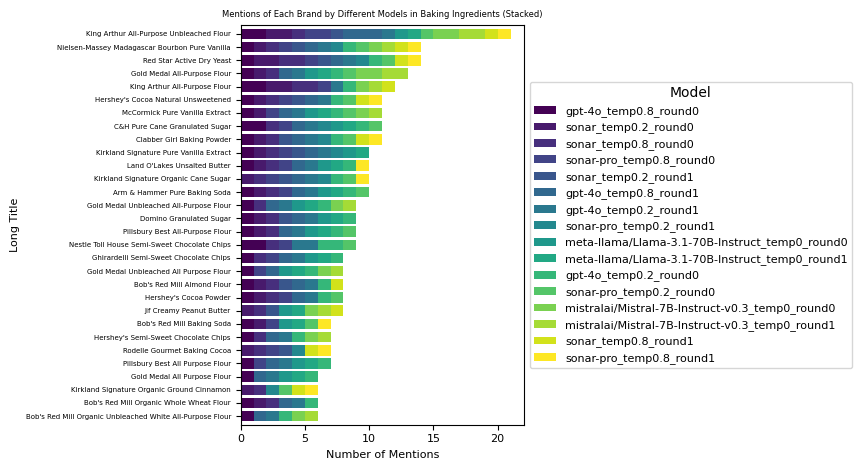

<Figure size 38400x28800 with 0 Axes>

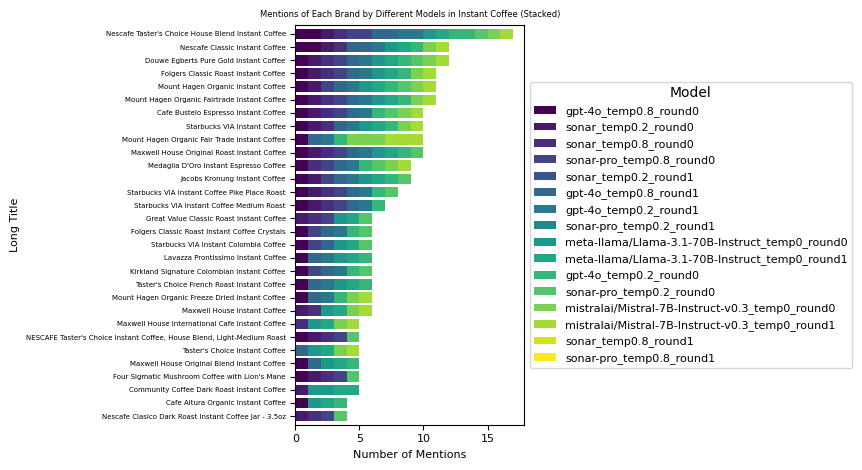

<Figure size 38400x28800 with 0 Axes>

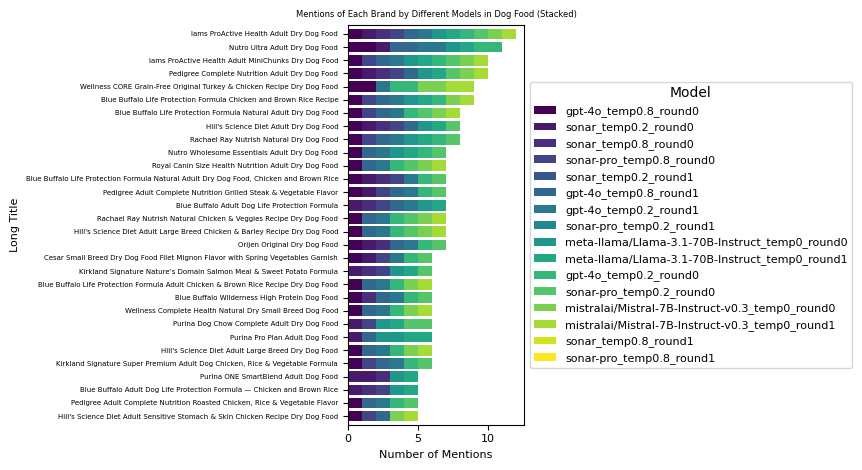

<Figure size 38400x28800 with 0 Axes>

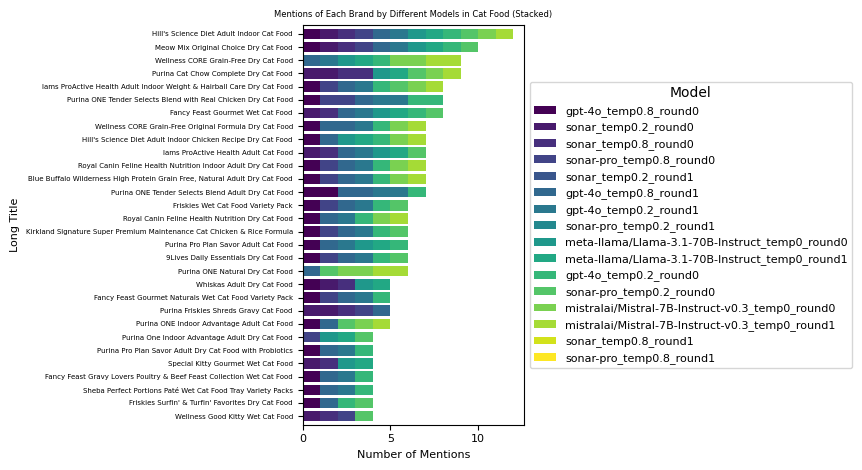

<Figure size 38400x28800 with 0 Axes>

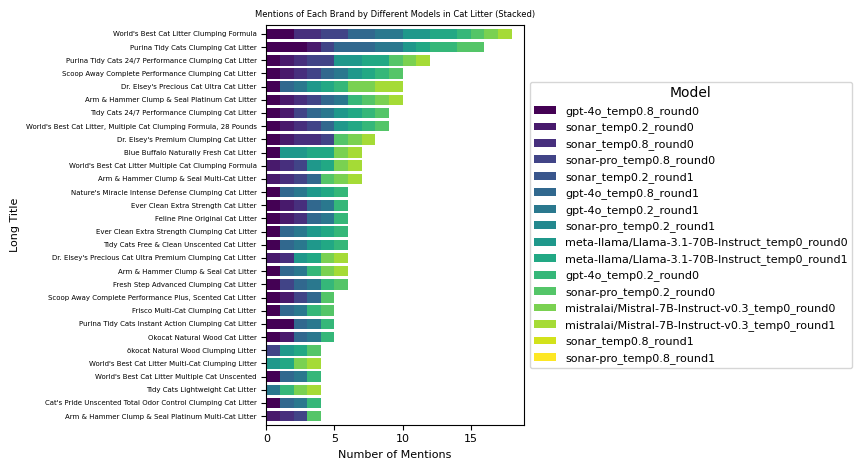

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
# Define the model columns
model_columns = [
    "gpt-4o_temp0.8_round0",
    "sonar_temp0.2_round0",
    "sonar_temp0.8_round0",
    "sonar-pro_temp0.8_round0",
    "sonar_temp0.2_round1",
    "gpt-4o_temp0.8_round1",
    "gpt-4o_temp0.2_round1",
    "sonar-pro_temp0.2_round1",
    "meta-llama/Llama-3.1-70B-Instruct_temp0_round0",
    "meta-llama/Llama-3.1-70B-Instruct_temp0_round1",
    "gpt-4o_temp0.2_round0",
    "sonar-pro_temp0.2_round0",
    "mistralai/Mistral-7B-Instruct-v0.3_temp0_round0",
    "mistralai/Mistral-7B-Instruct-v0.3_temp0_round1",
    "sonar_temp0.8_round1",
    "sonar-pro_temp0.8_round1",
]

# Get unique categories
categories = df_filtered["category"].unique()

# Create a separate plot for each category
for category in categories:
    # Filter the data for the current category
    category_df = df_filtered[df_filtered["category"] == category]
    
    # Count mentions for each brand by each model
    brand_model_counts = category_df.groupby("long_title")[model_columns].count()
    
    # Calculate the total mentions for each brand
    brand_model_counts["Total Mentions"] = brand_model_counts.sum(axis=1)
    
    # Sort the brands by total mentions (from highest to lowest)
    brand_model_counts = brand_model_counts.sort_values(by="Total Mentions", ascending=False)
    
    # Select only the top 30 brands (or adjust as needed)
    brand_model_counts = brand_model_counts.head(30)
    
    # Drop the 'Total Mentions' column for plotting
    brand_model_counts = brand_model_counts.drop(columns="Total Mentions")
    
    # Reverse the DataFrame order so that highest counts appear at the top in a horizontal bar chart
    brand_model_counts = brand_model_counts.iloc[::-1]
    
    # Plot the stacked horizontal bar chart
    plt.figure(dpi=6000)
    brand_model_counts.plot(kind="barh", stacked=True, colormap="viridis", width=0.8)
    
    # Add labels and title
    plt.xlabel("Number of Mentions", fontsize=8)
    plt.ylabel("Long Title", fontsize=8)
    plt.title(f"Mentions of Each Brand by Different Models in {category} (Stacked)", fontsize=6)
    plt.yticks(fontsize=5)
    plt.xticks(fontsize=8)
    # Adjust layout and display the plot
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.legend(title="Model", fontsize=8, loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()


<Figure size 38400x28800 with 0 Axes>

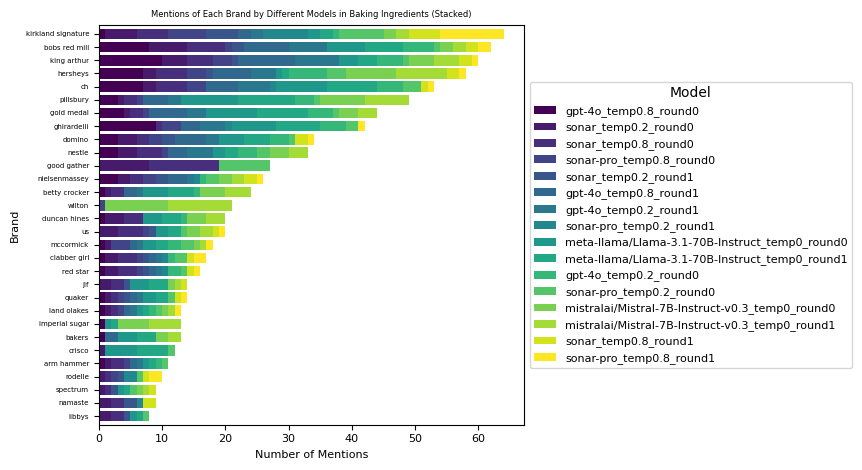

<Figure size 38400x28800 with 0 Axes>

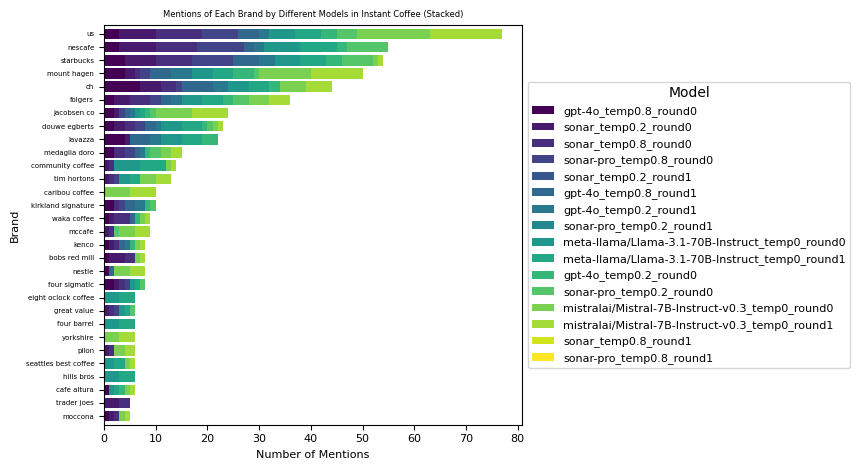

<Figure size 38400x28800 with 0 Axes>

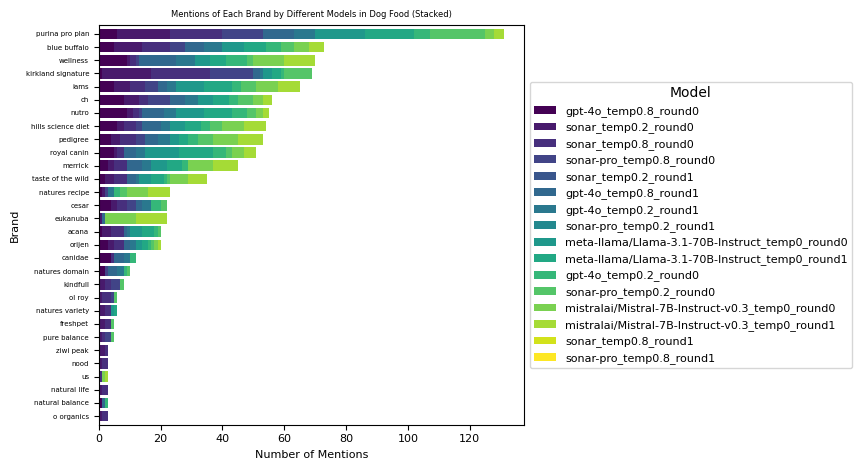

<Figure size 38400x28800 with 0 Axes>

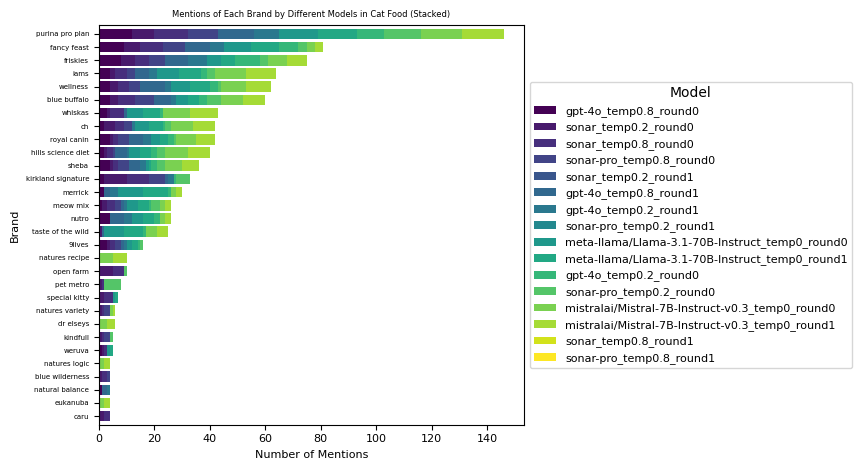

<Figure size 38400x28800 with 0 Axes>

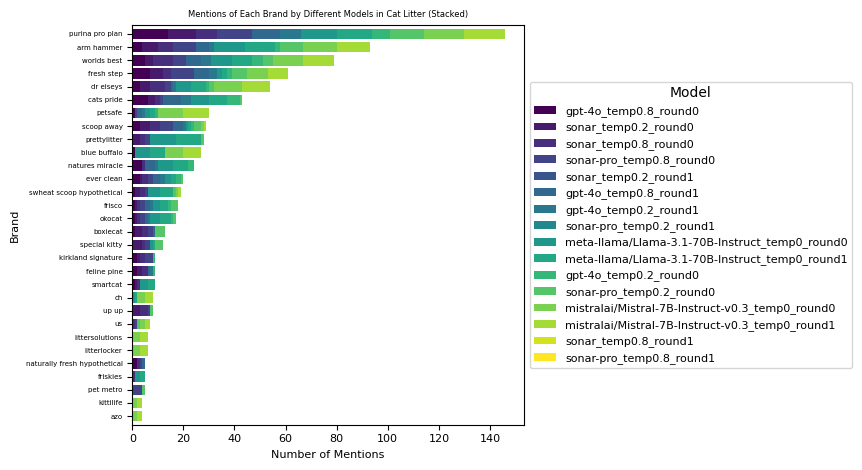

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Load the data
# df = pd.read_csv("df_openai_ranking_results.csv")

# # Define the model columns
# model_columns = [
#     "gpt-4o_temp0.8_round0",
#     "sonar_temp0.2_round0",
#     "sonar_temp0.8_round0",
#     "sonar-pro_temp0.8_round0",
#     "sonar_temp0.2_round1",
#     "gpt-4o_temp0.8_round1",
#     "gpt-4o_temp0.2_round1",
#     "sonar-pro_temp0.2_round1",
#     "meta-llama/Llama-3.1-70B-Instruct_temp0_round0",
#     "meta-llama/Llama-3.1-70B-Instruct_temp0_round1",
#     "gpt-4o_temp0.2_round0",
#     "sonar-pro_temp0.2_round0",
#     "mistralai/Mistral-7B-Instruct-v0.3_temp0_round0",
#     "mistralai/Mistral-7B-Instruct-v0.3_temp0_round1",
#     "sonar_temp0.8_round1",
#     "sonar-pro_temp0.8_round1",
# ]

# Get unique categories
categories = df_filtered["category"].unique()

# Create a separate plot for each category
for category in categories:
    # Filter the data for the current category
    category_df = df_filtered[df_filtered["category"] == category]
    
    # Count mentions for each brand by each model
    brand_model_counts = category_df.groupby("brand")[model_columns].count()
    
    # Calculate the total mentions for each brand
    brand_model_counts["Total Mentions"] = brand_model_counts.sum(axis=1)
    
    # Sort the brands by total mentions (from highest to lowest)
    brand_model_counts = brand_model_counts.sort_values(by="Total Mentions", ascending=False)
    
    # Select only the top 30 brands (or adjust as needed)
    brand_model_counts = brand_model_counts.head(30)
    
    # Drop the 'Total Mentions' column for plotting
    brand_model_counts = brand_model_counts.drop(columns="Total Mentions")
    
    # Reverse the DataFrame order so that highest counts appear at the top in a horizontal bar chart
    brand_model_counts = brand_model_counts.iloc[::-1]
    
    # Plot the stacked horizontal bar chart
    plt.figure(dpi=6000)
    brand_model_counts.plot(kind="barh", stacked=True, colormap="viridis", width=0.8)
    
    # Add labels and title
    plt.xlabel("Number of Mentions", fontsize=8)
    plt.ylabel("Brand", fontsize=8)
    plt.title(f"Mentions of Each Brand by Different Models in {category} (Stacked)", fontsize=6)
    plt.yticks(fontsize=5)
    plt.xticks(fontsize=8)
    # Adjust layout and display the plot
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.legend(title="Model", fontsize=8, loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()


# LLM Websearch - Openperplex

In [ ]:
import pandas as pd
import time
import re
from openperplex import OpenperplexSync
from datetime import datetime

In [ ]:
# purchased api key
PERPLEXITY_API_KEY = "REPLACE WITH YOUR OWN"
client_sync = OpenperplexSync(PERPLEXITY_API_KEY)
date_contexts = [
    "Today is Wednesday 9 of April 2025 and the time is 11:00 AM",
]

products = [
    "Baking Ingredients",
    "Instant Coffee",
    "Dog Food",
    "Cat Food",
    "Cat Litter"
]

def parse_date_context(date_context):
    """
    Parse the date_context string to extract the date and time,
    and return a formatted timestamp string in "YYYY-MM-DD HH:MM:SS" format.
    Example date_context: "Today is Monday 16 of September 2024 and the time is 6:36 PM"
    """
    pattern = r"(\d{1,2}) of (\w+) (\d{4}).*?(\d{1,2}:\d{2} (?:AM|PM))"
    match = re.search(pattern, date_context)
    if match:
        day, month, year, time_str = match.groups()
        dt_str = f"{day} {month} {year} {time_str}"
        dt = datetime.strptime(dt_str, "%d %B %Y %I:%M %p")
        return dt.strftime("%Y-%m-%d %H:%M:%S")
    else:
        # Fallback to current time if parsing fails
        return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

def extract_product_info(response_text):
    """
    Extract product information from the LLM response text.
    Each product block is assumed to start with "Product Title:" and blocks are separated by a blank line.
    """
    product_info = []
    product_blocks = response_text.strip().split('\n\n')
    for block in product_blocks:
        title_match = re.search(r"Product Title:\s*(.*)", block)
        description_match = re.search(r"Description:\s*(.*)", block)
        brand_match = re.search(r"Brand:\s*(.*)", block)
        retailer_match = re.search(r"Retailer:\s*(.*)", block)
        source_match = re.search(r"Source URL:\s*(http[s]?://\S+)", block)
        comments_match = re.search(r"Comments:\s*(.*)", block)
        
        title = title_match.group(1) if title_match else "N/A"
        description = description_match.group(1) if description_match else "N/A"
        brand = brand_match.group(1) if brand_match else "N/A"
        retailer = retailer_match.group(1) if retailer_match else "N/A"
        source = source_match.group(1) if source_match else "N/A"
        comments = comments_match.group(1) if comments_match else "N/A"
        
        product_info.append({
            "Title": title,
            "Description": description,
            "Brand": brand,
            "Retailer": retailer,
            "Source": source,
            "Comments": comments
        })
    return product_info

return_images = True
# Loop over each date_context value
for date_context in date_contexts:
    data = []  # Initialize data for each date_context separately
    print(f"Using date context: {date_context}")
    
    # Parse the date_context to get a timestamp aligned with it
    timestamp = parse_date_context(date_context)
    # Also extract just the date portion in YYYYMMDD format for the file name
    file_date_context = datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S").strftime("%Y%m%d")
    
    for product in products:
        query = f"""
        Provide the top 30 best products for {product}.
        For each product, return the following details in this exact format:

        Product Title: [Title]
        Description: [Description]
        Brand: [Brand]
        Retailer: [Retailer]
        Source URL: [URL]
        Comments: [Comments]

        Make sure to return the details for all products in the exact format above, one after the other.
        IMPORTANT: Please include the data for these keys for all searches.
        """
        print(f"Perplexity Web Searching for {product}: {query}")
        try:
            response = client_sync.search(
                query=query,
                model='o3-mini-high',
                response_language="en",
                answer_type="text",
                date_context=date_context,
                return_images=return_images
            )
            print("API Response:", response)
            response_text = response.get("llm_response", "")
            product_info = extract_product_info(response_text)
            image_urls = response.get("images", []) if return_images else []
            
            for idx, info in enumerate(product_info):
                data.append({
                    "Product Category": product,
                    "Search Source": "Perplexity",
                    "Title": info["Title"],
                    "Description": info["Description"],
                    "Brand": info["Brand"],
                    "Retailer": info["Retailer"],
                    "Source": info["Source"],
                    "Comments": info["Comments"],
                    "Image URL": image_urls[idx] if idx < len(image_urls) else "N/A",
                    "Timestamp": timestamp,
                })
            time.sleep(2)
        except Exception as e:
            print(f"Error during Perplexity API call for {product} with date context '{date_context}': {e}")
            continue

    if data:
        df = pd.DataFrame(data)
        file_name = f"perplexity_search_results_{file_date_context}.csv"
        try:
            df.to_csv(file_name, index=False)
            print(f"CSV file saved successfully as '{file_name}'!")
        except Exception as e:
            print(f"Error saving CSV for date context '{date_context}': {e}")
    else:
        print(f"No data was collected for date context '{date_context}'. Please check your API key, network connection, and query parameters.")

Using date context: Today is Wednesday 9 of April 2025 and the time is 11:00 AM
Perplexity Web Searching for Baking Ingredients: 
        Provide the top 30 best products for Baking Ingredients.
        For each product, return the following details in this exact format:

        Product Title: [Title]
        Description: [Description]
        Brand: [Brand]
        Retailer: [Retailer]
        Source URL: [URL]
        Comments: [Comments]

        Make sure to return the details for all products in the exact format above, one after the other.
        IMPORTANT: Please include the data for these keys for all searches.
        
Error during Perplexity API call for Baking Ingredients with date context 'Today is Wednesday 9 of April 2025 and the time is 11:00 AM': The read operation timed out
Perplexity Web Searching for Instant Coffee: 
        Provide the top 30 best products for Instant Coffee.
        For each product, return the following details in this exact format:

        Prod

In [22]:
import pandas as pd
import re
from unidecode import unidecode
import matplotlib.pyplot as plt

files = {
    '20250325': 'perplexity_search_results_20250325.csv',
    '20250326': 'perplexity_search_results_20250326.csv',
    '20250327': 'perplexity_search_results_20250327.csv',
    '20250328': 'perplexity_search_results_20250328.csv',
}

# For each CSV file, group normalized titles by product category (keeping category as-is)
category_titles = {}
for key, path in files.items():
    df = pd.read_csv(path)
    # Normalize Title while leaving Product Category unchanged
    df['Normalized_Title'] = df['Title'].apply(normalize_name)
    
    cat_dict = {}
    # Group normalized titles by their product category
    for cat, title in zip(df['Product Category'], df['Normalized_Title']):
        if pd.isnull(cat):
            continue
        if cat not in cat_dict:
            cat_dict[cat] = set()
        cat_dict[cat].add(title)
    category_titles[key] = cat_dict

def jaccard_similarity(set1, set2):
    """Compute Jaccard similarity as a percentage."""
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return (intersection / union * 100) if union else 0

# Compute pairwise overlap percentages and print unmatched titles for each product category.
results = {}  # Structure: {(file1, file2, product_category): overlap_percentage}
file_keys = list(category_titles.keys())

for i in range(len(file_keys)):
    for j in range(i+1, len(file_keys)):
        file1 = file_keys[i]
        file2 = file_keys[j]
        # All product categories present in either file
        all_categories = set(category_titles[file1].keys()) | set(category_titles[file2].keys())
        for category in all_categories:
            titles1 = category_titles[file1].get(category, set())
            titles2 = category_titles[file2].get(category, set())
            overlap_percentage = jaccard_similarity(titles1, titles2)
            results[(file1, file2, category)] = overlap_percentage
            
            # Compute differences
            diff1 = titles1 - titles2
            diff2 = titles2 - titles1
            
            print(f"Comparing category '{category}' between {file1} and {file2}:")
            print(f"Overlap: {overlap_percentage:.2f}%")
            if diff1:
                print(f"Titles in {file1} not in {file2} ({len(diff1)}):")
                for title in diff1:
                    print(f"  - {title}")
            else:
                print(f"All titles in {file1} match those in {file2} for category '{category}'.")
            if diff2:
                print(f"Titles in {file2} not in {file1} ({len(diff2)}):")
                for title in diff2:
                    print(f"  - {title}")
            else:
                print(f"All titles in {file2} match those in {file1} for category '{category}'.")
            print("-" * 60)


Comparing category 'Dog Food' between 20250325 and 20250326:
Overlap: 0.00%
Titles in 20250325 not in 20250326 (10):
  - orijen original grainfree dry dog food
  - wellness core grainfree original dry dog food
  - royal canin size health nutrition small adult dry dog food
  - nutro ultra adult dry dog food
  - blue buffalo life protection formula adult dry dog food
  - hills science diet adult dog food
  - purina pro plan savor adult dry dog food
  - solid gold leaping waters dry dog food
  - taste of the wild high protein grainfree dry dog food
  - merrick grain free dry dog food
Titles in 20250326 not in 20250325 (10):
  - we feed raw dog food review raw frozen
  - hills science diet adult sensitive stomach dog food
  - merrick grain free dog food
  - royal canin breed health nutrition
  - ollie dog food review fresh
  - redbarn grain free dog food dry
  - blue buffalo wet dog food
  - the farmers dog fresh dog food
  - nom nom dog food review fresh
  - purina pro plan dog food
-----

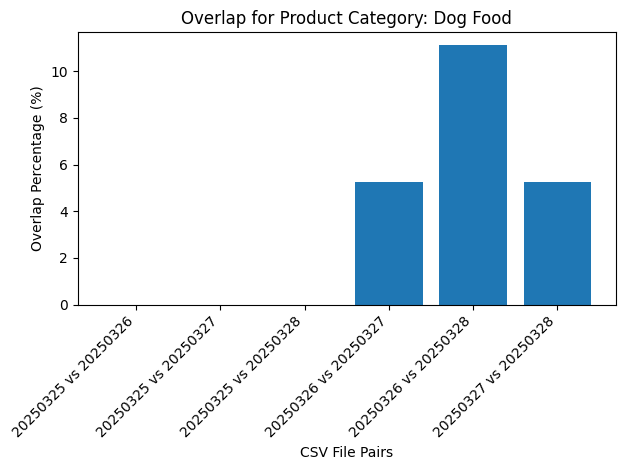

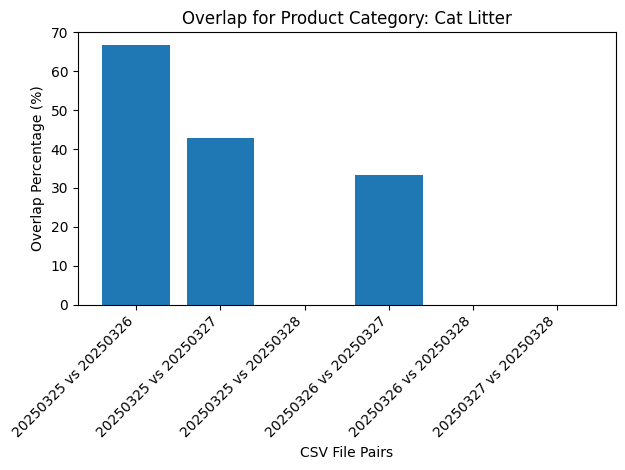

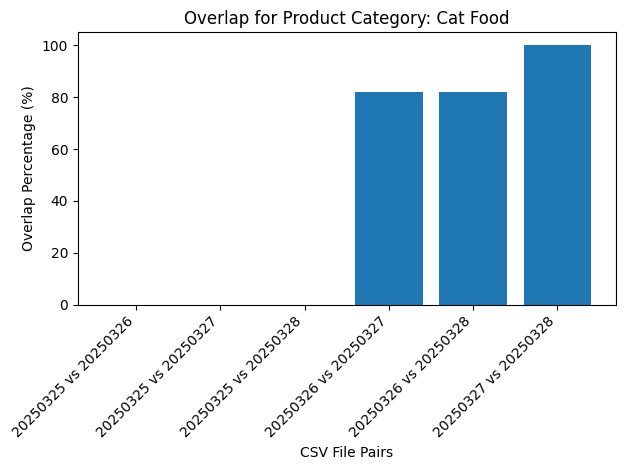

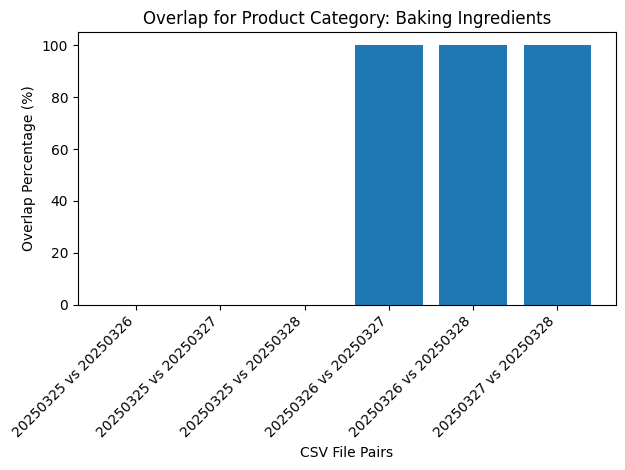

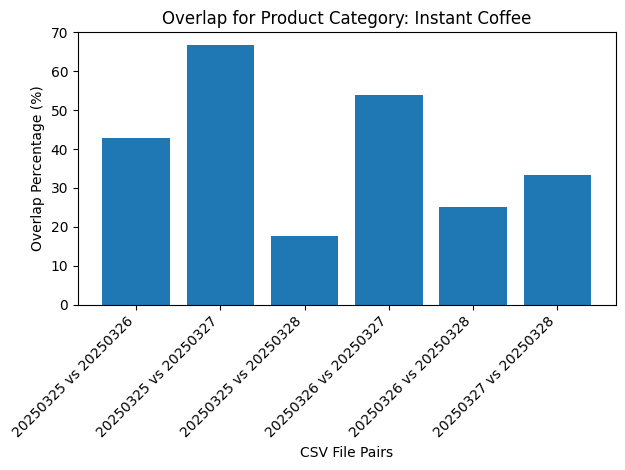

In [20]:
# Organize results by product category for visualization.
results_by_category = {}
for (file1, file2, category), percent in results.items():
    if category not in results_by_category:
        results_by_category[category] = []
    results_by_category[category].append((f"{file1} vs {file2}", percent))

# Create one bar chart per product category.
for category, comparisons in results_by_category.items():
    pairs = [pair for pair, _ in comparisons]
    percentages = [percent for _, percent in comparisons]
    
    plt.figure()
    plt.bar(pairs, percentages)
    plt.ylabel("Overlap Percentage (%)")
    plt.xlabel("CSV File Pairs")
    plt.title(f"Overlap for Product Category: {category}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [23]:
import pandas as pd
import re
from unidecode import unidecode
import difflib

def are_titles_similar(title1, title2, threshold=0.8):
    """
    Compare two titles using a similarity ratio.
    Returns True if similarity is at or above the threshold.
    """
    ratio = difflib.SequenceMatcher(None, title1, title2).ratio()
    return ratio >= threshold

# File paths for the original and updated CSV files
old_csv = 'perplexity_search_results_20250325.csv'
new_csv = 'perplexity_search_results_20250326.csv'

# Read CSV files into DataFrames
df_old = pd.read_csv(old_csv)
df_new = pd.read_csv(new_csv)

# Validate the existence of the "Title" column
if 'Title' not in df_old.columns or 'Title' not in df_new.columns:
    raise ValueError("The 'Title' column must exist in both CSV files.")

# Normalize the "Title" column in both DataFrames
df_old['Normalized_Title'] = df_old['Title'].apply(normalize_name)
df_new['Normalized_Title'] = df_new['Title'].apply(normalize_name)

# Fuzzy Matching
# Use fuzzy matching on the normalized titles to decide if differences are significant
comparison_df_fuzzy = pd.DataFrame({
    'Title_round1': df_old['Normalized_Title'],
    'Title_round2': df_new['Normalized_Title']
})

# Mark rows as similar if their fuzzy similarity is above the threshold
comparison_df_fuzzy['Is_Similar'] = comparison_df_fuzzy.apply(
    lambda row: are_titles_similar(row['Title_round1'], row['Title_round2'], threshold=0.8), axis=1
)

changed_fuzzy = comparison_df_fuzzy[~comparison_df_fuzzy['Is_Similar']]

print("\nRows with changed 'Title' based on fuzzy matching:")
print(changed_fuzzy[['Title_round1', 'Title_round2']])



Rows with changed 'Title' based on fuzzy matching:
                                         Title_round1  \
0             king arthur unbleached allpurpose flour   
1             bobs red mill organic whole wheat flour   
2                         gold medal allpurpose flour   
3                                   normas cane sugar   
4                             dr oetker baking powder   
5                   hodgson mill organic almond flour   
6                   valrhona unsweetened cocoa powder   
7                            dawn foods instant yeast   
8                  ghirardelli baking chocolate chips   
9                      mccormick pure vanilla extract   
16      cafe grumpy heartbreaker blend instant coffee   
17        cafe grumpy decaf costa rica instant coffee   
18              swift coffee one of everything bundle   
19                              kloo mini tasting set   
20  blue buffalo life protection formula adult dry...   
21                  hills science di

# Offline LLMs Result Comparison with Google Search/Google Shopping and Perplexity results

In [ ]:
import pandas as pd
google_search = pd.read_csv("GoogleSearch_Data.csv")
google_shopping = pd.read_csv("GoogleShopping_Data.csv")
perplexity_data = pd.read_csv("perplexity_search_results.csv")
llm_data = pd.read_csv("df_filtered.csv")

In [60]:
google_search_titles = list(google_search["Product Title"])
google_shopping_titles = list(google_shopping["Product long title"])
perplexity_data_titles = list(perplexity_data["Title"])
llm_data_titles = list(llm_data["long_title"])

In [7]:
perplexity_data_titles

['King Arthur Unbleached All-Purpose Flour  ',
 "Bob's Red Mill Organic Whole Wheat Flour  ",
 'Gold Medal All-Purpose Flour  ',
 "Norma's Cane Sugar  ",
 'Dr. Oetker Baking Powder  ',
 'Hodgson Mill Organic Almond Flour  ',
 'Valrhona Unsweetened Cocoa Powder  ',
 'Dawn Foods Instant Yeast  ',
 'Ghirardelli Baking Chocolate Chips  ',
 'McCormick Pure Vanilla Extract  ',
 'Sightglass Instant La Magdalena Tolima  ',
 'Canyon Instant Coffee  ',
 'Verve Coffee Roasters Streetlevel Craft Instant Coffee  ',
 'Mount Hagen Organic Single Serve Instant Coffee  ',
 'Blue Bottle Craft Instant Espresso  ',
 'Swift Coffee Mainstay  ',
 'Cafe Grumpy Heartbreaker Blend Instant Coffee  ',
 'Cafe Grumpy Decaf Costa Rica Instant Coffee  ',
 'Swift Coffee "One of Everything" Bundle  ',
 'Kloo Mini Tasting Set  ',
 'Blue Buffalo Life Protection Formula Adult Dry Dog Food  ',
 'Hill’s Science Diet Adult Dog Food  ',
 'Taste of the Wild High Protein Grain-Free Dry Dog Food  ',
 'Orijen Original Grain-Free 

In [63]:
normalized_search_titles = []
normalized_shopping_titles = []
normalized_perplexity_titles = []
normalized_llm_titles = []
for i in google_search_titles:
    normalized_search_titles.append(normalize_name(i))
for i in google_shopping_titles:
    normalized_shopping_titles.append(normalize_name(i))
for i in perplexity_data_titles:
    normalized_perplexity_titles.append(normalize_name(i))
for i in llm_data_titles:
    normalized_llm_titles.append(normalize_name(i))

In [70]:
normalized_perplexity_titles

['king arthur unbleached allpurpose flour',
 'bobs red mill organic whole wheat flour',
 'gold medal allpurpose flour',
 'normas cane sugar',
 'dr oetker baking powder',
 'hodgson mill organic almond flour',
 'valrhona unsweetened cocoa powder',
 'dawn foods instant yeast',
 'ghirardelli baking chocolate chips',
 'mccormick pure vanilla extract',
 'sightglass instant la magdalena tolima',
 'canyon instant coffee',
 'verve coffee roasters streetlevel craft instant coffee',
 'mount hagen organic single serve instant coffee',
 'blue bottle craft instant espresso',
 'swift coffee mainstay',
 'cafe grumpy heartbreaker blend instant coffee',
 'cafe grumpy decaf costa rica instant coffee',
 'swift coffee one of everything bundle',
 'kloo mini tasting set',
 'blue buffalo life protection formula adult dry dog food',
 'hills science diet adult dog food',
 'taste of the wild high protein grainfree dry dog food',
 'orijen original grainfree dry dog food',
 'royal canin size health nutrition small

In [73]:
def jaccard_similarity(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    print(set1 & set2)
    return intersection / union if union else 0

set1 = set(normalized_search_titles)
set2 = set(normalized_shopping_titles)
set3 = set(normalized_perplexity_titles)
set4 = set(normalized_llm_titles)
sim_13 = jaccard_similarity(set1, set3)
print(f"Jaccard 1-3: {sim_13:.3f}\n")
sim_23 = jaccard_similarity(set2, set3)
print(f"Jaccard 2-3: {sim_23:.3f}\n")
sim_14 = jaccard_similarity(set1, set4)
print(f"Jaccard 1-4: {sim_14:.3f}\n")
sim_24 = jaccard_similarity(set2, set4)
print(f"Jaccard 2-4: {sim_24:.3f}")

{'tidy cats breeze litter box system', 'blue bottle craft instant espresso', 'worlds best cat litter', 'dr elseys precious cat ultra unscented', 'fresh news recycled paper litter', 'canyon instant coffee', 'tuft  paw really great cat litter', 'catalyst pet multicat formula cat litter'}
Jaccard 1-3: 0.034

set()
Jaccard 2-3: 0.000

{'smartcat unscented clumping grass litter', 'frisco micro crystal unscented nonclumping litter', 'cafe bustelo espresso instant coffee', 'blue buffalo life protection formula', 'royal canin feline health nutrition indoor adult dry cat food', 'o organics instant coffee', 'tidy cats breeze litter box system', 'valrhona cocoa powder', 'fresh news recycled paper litter', 'canidae all life stages multiprotein formula', 'twin peaks original pour over 100 colombian coffee', 'worlds best cat litter multiple cat unscented', 'arm  hammer clump  seal multicat litter', 'catalyst pet multicat formula cat litter', 'royal canin size health nutrition medium adult formula', 

In [ ]:
import difflib
from collections import defaultdict

# fuzzy matching
all_brands = defaultdict(list)
for brand in normalized_search_titles + normalized_shopping_titles + normalized_perplexity_titles + normalized_llm_titles:
    all_brands[brand].append(brand)

potential_matches = {k: v for k, v in all_brands.items() if len(v) > 1}
print("\nPotential similar brands (different expressions of same product):")
for cleaned, originals in potential_matches.items():
    print(f"Similar to '{cleaned}':")
    for orig in originals:
        print(f"  - {orig}")
    print()

print("\nAdditional potential matches using fuzzy string matching:")
threshold = 0.7

sets = [set1, set2, set3, set4]
set_labels = ["A", "B", "C", "D"]

# Compare brands across all unique pairs of sets
for i in range(len(sets)):
    for j in range(i + 1, len(sets)):
        set_a = sets[i]
        set_b = sets[j]
        label_a = set_labels[i]
        label_b = set_labels[j]

        for brand_a in set_a:
            for brand_b in set_b:
                similarity = difflib.SequenceMatcher(None, brand_a, brand_b).ratio()
                if similarity >= threshold and brand_a != brand_b:
                    print(f"Potential match: '{brand_a}' ({label_a}) <-> '{brand_b}' ({label_b}) [similarity: {similarity:.2f}]")



Potential similar brands (different expressions of same product):
Similar to 'blue buffalo life protection formula':
  - blue buffalo life protection formula
  - blue buffalo life protection formula

Similar to 'taste of the wild high prairie canine recipe':
  - taste of the wild high prairie canine recipe
  - taste of the wild high prairie canine recipe

Similar to 'royal canin size health nutrition medium adult formula':
  - royal canin size health nutrition medium adult formula
  - royal canin size health nutrition medium adult formula

Similar to 'canidae all life stages multiprotein formula':
  - canidae all life stages multiprotein formula
  - canidae all life stages multiprotein formula

Similar to 'orijen original dry dog food':
  - orijen original dry dog food
  - orijen original dry dog food

Similar to 'the farmers dog':
  - the farmers dog
  - the farmers dog

Similar to 'blue buffalo':
  - blue buffalo
  - blue buffalo

Similar to 'purina':
  - purina
  - purina
  - purin

In [76]:
# fuzzy matching
from rapidfuzz import fuzz

def avg_fuzzy_similarity(set1, set2):
    total = 0
    count = 0
    for s1 in set1:
        for s2 in set2:
            total += fuzz.token_set_ratio(s1, s2)
            count += 1
    return total / count if count else 0

similarityAC = avg_fuzzy_similarity(normalized_search_titles, normalized_perplexity_titles)
similarityBC = avg_fuzzy_similarity(normalized_shopping_titles, normalized_perplexity_titles)
print(f"Avg Fuzzy Similarity AC: {similarityAC:.2f}")
print(f"Avg Fuzzy Similarity BC: {similarityBC:.2f}")

Avg Fuzzy Similarity AC: 32.48
Avg Fuzzy Similarity BC: 38.01


In [81]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

def semantic_set_similarity(set_a, set_b, threshold=0.8, print_matches=False, label_a="A", label_b="B"):
    emb_a = model.encode(list(set_a), convert_to_tensor=True)
    emb_b = model.encode(list(set_b), convert_to_tensor=True)
    
    sim_matrix = cosine_similarity(emb_a.cpu(), emb_b.cpu())
    best_match_indices = sim_matrix.argmax(axis=1)
    best_match_scores = sim_matrix.max(axis=1)
    
    matches_above_threshold = (best_match_scores > threshold).sum()
    similarity_score = matches_above_threshold / max(len(set_a), len(set_b))
    
    if print_matches:
        print(f"\nMatched Pairs ({label_a} <-> {label_b}) (Score >= {threshold}):")
        for i, (score, j) in enumerate(zip(best_match_scores, best_match_indices)):
            if score >= threshold:
                print(f"'{list(set_a)[i]}' ({label_a}) <-> '{list(set_b)[j]}' ({label_b}) (Score: {score:.3f})")
        
        # print(f"\nUnmatched Items from {label_a}:")
        # for i, (score, j) in enumerate(zip(best_match_scores, best_match_indices)):
        #     if score < threshold:
        #         print(f"'{list(set_a)[i]}' (Best Match: '{list(set_b)[j]}', Score: {score:.3f})")
    
    return similarity_score

# Compare all unique pairs of sets
sets = [set1, set2, set3, set4]
labels = ["A", "B", "C", "D"]

print("\nSemantic Similarity Scores Across Set Pairs:")
for i in range(len(sets)):
    for j in range(i + 1, len(sets)):
        score = semantic_set_similarity(sets[i], sets[j], threshold=0.8, print_matches=True, label_a=labels[i], label_b=labels[j])
        print(f"Similarity {labels[i]} <-> {labels[j]}: {score:.2f}")



Semantic Similarity Scores Across Set Pairs:

Matched Pairs (A <-> B) (Score >= 0.8):
'meow mix original choice dry cat food 63 pound bag' (A) <-> 'meow mix original choice dry cat food' (B) (Score: 0.857)
'tidy cats breeze litter box system' (A) <-> 'purina tidy cats clumping cat litter' (B) (Score: 0.831)
'purina tidy cats' (A) <-> 'purina tidy cats clumping cat litter' (B) (Score: 0.915)
'pedigree chopped ground dinner wet dog food filet mignon  beef variety pack 132 oz cans 12 count pack of 1' (A) <-> 'cesar soft wet dog food filets in gravy variety pack' (B) (Score: 0.809)
'purina pro plan small breed dog food with probiotics for dogs shredded blend chicken  rice formula  6 lb bag' (A) <-> 'purina pro plan adult shredded blend chicken  rice dry dog food' (B) (Score: 0.849)
'kuju coffee' (A) <-> 'nescafe coffee instant' (B) (Score: 0.833)
'sheba perfect portions wet cat food cuts in gravy variety pack roasted chicken entree with sustainable salmon and tender turkey entree 26 oz tw

In [ ]:
import pandas as pd
file_path = "df_filtered.csv"
df = pd.read_csv(file_path)

In [ ]:
group_cols = ['category', 'brand', 'long_title']
ranking_cols = df.columns[7:]
df_filled = df.copy()
df_filled[ranking_cols] = df_filled[ranking_cols].fillna(11)

# df_filled['average_ranking'] = df_filled[ranking_cols].mean(axis=1)

df_filled['isTop3'] = df_filled[ranking_cols].apply(lambda row: any(rank <= 3 for rank in row), axis=1)

nestle_keywords = ['nestl', 'toll', 'nescaf', 'purina']
def is_nestle_product(row):
    text = f"{row['brand']} {row['long_title']}".lower()
    return any(keyword in text for keyword in nestle_keywords)
df_filled['isNestle'] = df_filled.apply(is_nestle_product, axis=1)
df_filled['isTop3Nestle'] = df_filled['isTop3'] & df_filled['isNestle']

mention_counts_by_cat = df_filled.groupby(group_cols).size().reset_index(name='mention_count')
# avg_rankings_by_cat = df_filled.groupby(group_cols)['average_ranking'].mean().reset_index()
top3_check_by_cat = df_filled.groupby(group_cols)['isTop3'].any().reset_index()
nestle_check_by_cat = df_filled.groupby(group_cols)['isNestle'].any().reset_index()
top3_nestle_check = df_filled.groupby(group_cols)['isTop3Nestle'].any().reset_index()

# category_insights_filled = mention_counts_by_cat.merge(avg_rankings_by_cat, on=group_cols)
# category_insights_filled = top3_check_by_cat.merge(top3_check_by_cat, on=group_cols)
category_insights_filled = top3_check_by_cat.merge(nestle_check_by_cat, on=group_cols)
category_insights_filled = category_insights_filled.merge(top3_nestle_check, on=group_cols)
category_insights_filled

,category,brand,long_title,isTop3,isNestle,isTop3Nestle
0,Baking Ingredients,alkanater,Alkanater Baking Ingredient,True,False,False
1,Baking Ingredients,almond breeze,Almond Breeze Unsweetened Almond Milk,False,False,False
2,Baking Ingredients,almond extract,"J.R. Watkins Almond Extract Pure Flavor, 4 oz",False,False,False
3,Baking Ingredients,amul,Amul Fresh Cream,False,False,False
4,Baking Ingredients,amul,Amul Unsalted Butter,True,False,False
...,...,...,...,...,...,...
2018,Instant Coffee,waka coffee,Waka Medium Roast Decaffeinated Instant Coffee,False,False,False
2019,Instant Coffee,whole foods,Whole Foods Instant Espresso,True,False,False
2020,Instant Coffee,yorkshire,Yorkshire Coffee Company Original Instant Coffee,False,False,False
2021,Instant Coffee,yorkshire,Yorkshire Gold Instant Coffee,False,False,False


In [ ]:
# Filter the DataFrame to include only products that are both in top 3 and Nestlé products
top3_nestle_products = category_insights_filled[category_insights_filled['isTop3Nestle'] == True]
top3_nestle_products

,category,brand,long_title,isTop3,isNestle,isTop3Nestle
327,Baking Ingredients,nestle,Nestle Baking Cocoa,True,True,True
328,Baking Ingredients,nestle,Nestle Semi-Sweet Chocolate Chips,True,True,True
335,Baking Ingredients,nestle,Nestle Toll House Semi-Sweet Chocolate Chips f...,True,True,True
338,Baking Ingredients,nestle,Semi-Sweet Chocolate Chips for Baking - 12oz,True,True,True
372,Baking Ingredients,purina pro plan,"Purina Unbleached All-Purpose Flour, 20 lbs",True,True,True
...,...,...,...,...,...,...
1925,Instant Coffee,nescafe,Nescafé Gold Espresso Instant Coffee,True,True,True
1927,Instant Coffee,nescafe,Nescafé Rich Instant Coffee,True,True,True
1930,Instant Coffee,nestle,Nescafe Clasico Low Acid Instant Coffee,True,True,True
1931,Instant Coffee,nestle,Nescafe Classic Instant Coffee,True,True,True


# LLMs UI Manually Collect - Chatgpt4o

In [10]:
import pandas as pd

# Load the uploaded CSV file
file_path = "ChatGPT4o-InstantCoffee-Wensha.csv"
df = pd.read_csv(file_path)

In [11]:
# 1. Count of unique prompts
unique_prompts = df['Prompt'].nunique()

# 2. Count of unique product names overall
unique_products = df['Product Name'].nunique()

# 3. Frequency count of each product
product_counts = df['Product Name'].value_counts()

# Convert to DataFrame for display
product_freq_df = product_counts.reset_index()
product_freq_df.columns = ['Product Name', 'Frequency']

# 4. Count of non-null URLs in each URL column
url_columns = ['URL1', 'URL2', 'URL3', 'URL4', 'URL5', 'URL6', 'URL7', 'URL8']
url_counts = df[url_columns].notna().sum()

# 5. Distribution of runs
run_distribution = df['Run'].value_counts().sort_index()

# 6. Unique products per prompt
unique_products_by_prompt = df.groupby('Prompt')['Product Name'].nunique().reset_index()
unique_products_by_prompt.columns = ['Prompt', 'Unique Product Count']
unique_products_by_prompt_df = unique_products_by_prompt.copy()

# Output the main analysis results
(product_freq_df, unique_products_by_prompt_df, unique_prompts, unique_products, url_counts, run_distribution)


(                                         Product Name  Frequency
 0                  Mount Hagen Organic Instant Coffee         27
 1                  Tim Hortons Premium Instant Coffee         14
 2                Nescafé Gold Espresso Instant Coffee         13
 3     Starbucks VIA Instant Coffee – Pike Place Roast         12
 4               Four Sigmatic Organic Mushroom Coffee          9
 5                    Anthony’s Organic Instant Coffee          8
 6                  Café Altura Organic Instant Coffee          8
 7                     Nescafé Taster’s Choice Classic          7
 8                     Just Us! Organic Instant Coffee          7
 9                  Waka Coffee Organic Instant Coffee          4
 10                   Blue Bottle Craft Instant Coffee          4
 11             Starbucks VIA Instant True North Blend          3
 12           Starbucks VIA Instant Coffee Colombia 8S          3
 13                         Juan Valdez Instant Coffee          3
 14       

In [35]:
unique_products_by_prompt_df

,Prompt,Unique Product Count
0,Best organic instant coffee brands? Include al...,10
1,What is the best instant coffee for flavor in ...,12
2,What is the best instant coffee for flavor in ...,14


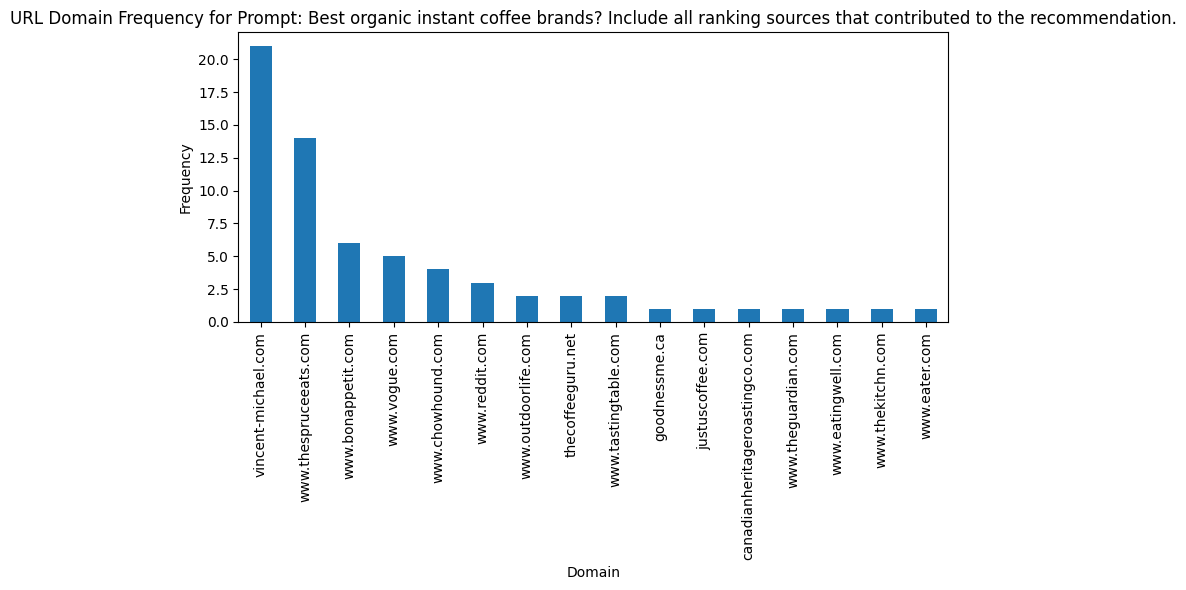

In [31]:
# Re-import libraries after code execution environment reset
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import urlparse


# Define URL columns
url_columns = ['URL1', 'URL2', 'URL3', 'URL4', 'URL5', 'URL6', 'URL7', 'URL8']

# Function to extract domain from URL
def extract_domain(url):
    try:
        return urlparse(url).netloc
    except:
        return None

# Group by Prompt and count frequency of each URL domain
domain_frequency_by_prompt = {}

for prompt, group in df.groupby('Prompt'):
    urls = group[url_columns].values.flatten()
    urls = [url for url in urls if pd.notna(url)]
    domains = [extract_domain(url) for url in urls]
    domain_counts = pd.Series(domains).value_counts()
    domain_frequency_by_prompt[prompt] = domain_counts

# Plotting one plot at a time to avoid issues
plot_data = list(domain_frequency_by_prompt.items())
prompt, domain_counts = plot_data[0]

plt.figure(figsize=(8, 6))
domain_counts.plot(kind='bar')
plt.title(f'URL Domain Frequency for Prompt: {prompt}')
plt.xlabel('Domain')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


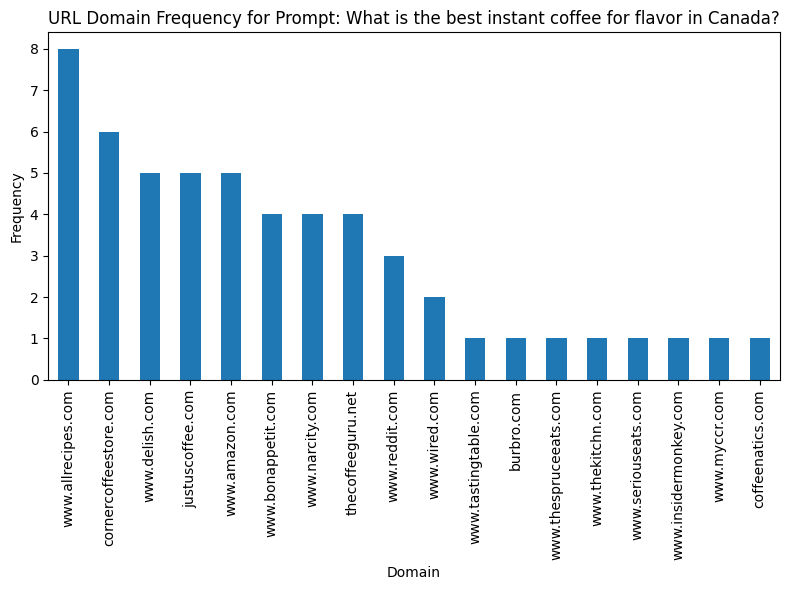

In [30]:
# Plot the second prompt's domain frequency

prompt, domain_counts = plot_data[1]

plt.figure(figsize=(8, 6))
domain_counts.plot(kind='bar')
plt.title(f'URL Domain Frequency for Prompt: {prompt}')
plt.xlabel('Domain')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


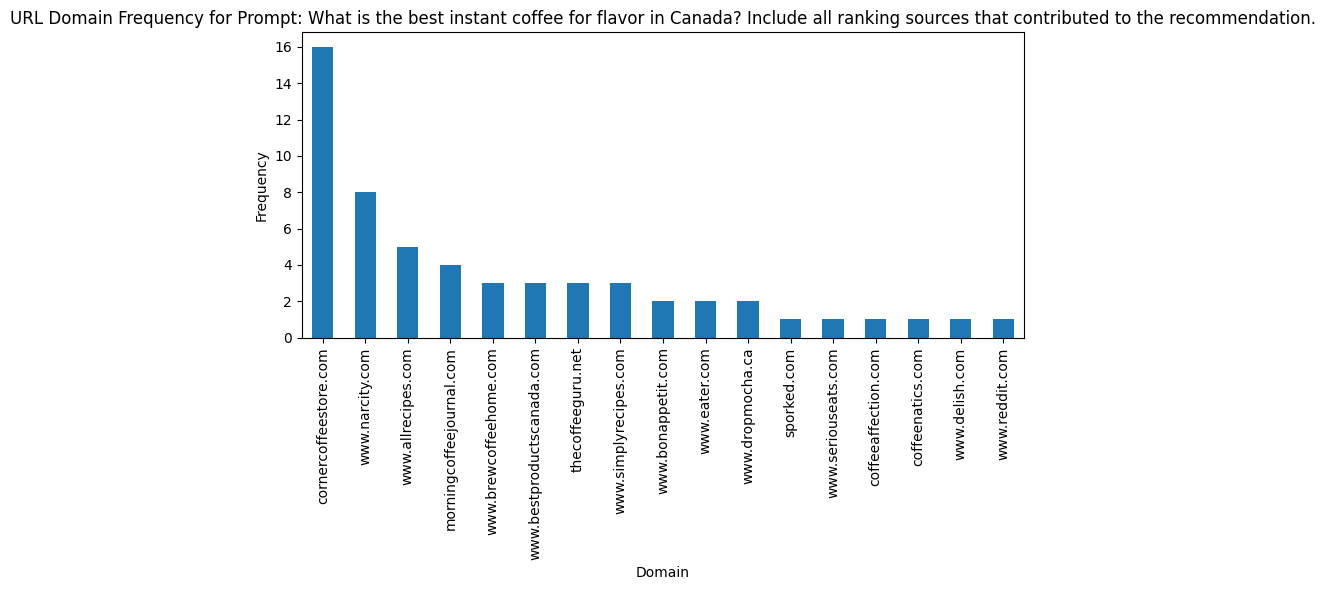

In [32]:
# Plot the third prompt's domain frequency

prompt, domain_counts = plot_data[2]

plt.figure(figsize=(8, 6))
domain_counts.plot(kind='bar')
plt.title(f'URL Domain Frequency for Prompt: {prompt}')
plt.xlabel('Domain')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [12]:
# unique link
# Gather all URL values from URL1 to URL8 columns
all_urls = pd.Series(dtype=str)
url_columns = ['URL1', 'URL2', 'URL3', 'URL4', 'URL5', 'URL6', 'URL7', 'URL8']
for col in url_columns:
    all_urls = pd.concat([all_urls, df[col].dropna()])

unique_sorted_urls = sorted(all_urls.unique())

# Convert to DataFrame for better viewing
urls_df = pd.DataFrame(unique_sorted_urls, columns=['URL'])
urls_df

,URL
0,https://burbro.com/best-instant-coffee-13055/?...
1,https://canadianheritageroastingco.com/product...
2,https://coffeeaffection.com/best-instant-coffe...
3,https://coffeenatics.com/coffee/best-instant-d...
4,https://cornercoffeestore.com/best-instant-cof...
5,https://cornercoffeestore.com/best-instant-cof...
6,https://cornercoffeestore.com/best-instant-cof...
7,https://goodnessme.ca/products/native-freeze-d...
8,https://justuscoffee.com/collections/favourite...
9,https://justuscoffee.com/products/organic-inst...


In [13]:
from urllib.parse import urlparse

# Function to clean URLs and keep only the main path before query and tracking params
def clean_url(url):
    parsed = urlparse(url)
    # Extract scheme and netloc and only the first path component if available
    path_parts = parsed.path.strip("/").split("/")
    main_path = "/".join(path_parts[:1])  # Keep only the first directory (e.g., 'best-instant-coffees-canada')
    return f"{parsed.scheme}://{parsed.netloc}/{main_path}"

# Apply cleaning
cleaned_urls = all_urls.dropna().apply(clean_url)

# Get unique and sorted
cleaned_urls_unique_sorted = sorted(cleaned_urls.unique())

# Convert to DataFrame
cleaned_urls_df = pd.DataFrame(cleaned_urls_unique_sorted, columns=['Cleaned URL'])
cleaned_urls_df

,Cleaned URL
0,https://burbro.com/best-instant-coffee-13055
1,https://canadianheritageroastingco.com/products
2,https://coffeeaffection.com/best-instant-coffe...
3,https://coffeenatics.com/coffee
4,https://cornercoffeestore.com/best-instant-coffee
5,https://cornercoffeestore.com/best-instant-cof...
6,https://goodnessme.ca/products
7,https://justuscoffee.com/collections
8,https://justuscoffee.com/products
9,https://morningcoffeejournal.com/best-instant-...


In [14]:
# Create a mapping of prompt to sets of unique product names
prompt_product_map = df.groupby('Prompt')['Product Name'].apply(set)

# Find unique products per prompt
prompt_list = prompt_product_map.index.tolist()
unique_sets = {prompt: prompt_product_map[prompt] for prompt in prompt_list}

# Compute exclusive and shared product names
comparison_results = {}

# Compare every prompt against others
for prompt in prompt_list:
    others = set().union(*(unique_sets[p] for p in prompt_list if p != prompt))
    exclusive = unique_sets[prompt] - others
    shared = unique_sets[prompt].intersection(others)
    comparison_results[prompt] = {
        'Exclusive Products': exclusive,
        'Shared Products': shared
    }

comparison_results

{'Best organic instant coffee brands? Include all ranking sources that contributed to the recommendation.': {'Exclusive Products': {'Anthony’s Organic Instant Coffee',
   'Café Altura Organic Instant Coffee',
   'Flash Fuel Organic Instant Coffee by Canadian Heritage Roasting Co.',
   'Four Sigmatic Organic Mushroom Coffee',
   'Native Organic Instant Coffee',
   'Nature’s Cuppa Organic Instant Coffee',
   'Swift Cup Instant Coffee',
   'Waka Coffee Organic Instant Coffee'},
  'Shared Products': {'Just Us! Organic Instant Coffee',
   'Mount Hagen Organic Instant Coffee'}},
 'What is the best instant coffee for flavor in Canada?': {'Exclusive Products': {'Café Bustelo Espresso Instant Coffee',
   'Colcafé Classic Instant Coffee',
   'Juan Valdez Instant Coffee'},
  'Shared Products': {'Intelligentsia Instant Coffee – House Blend',
   'Just Us! Organic Instant Coffee',
   'Maxwell House Original Roast',
   'Mount Hagen Organic Instant Coffee',
   'Nescafé Gold Espresso Instant Coffee',
 

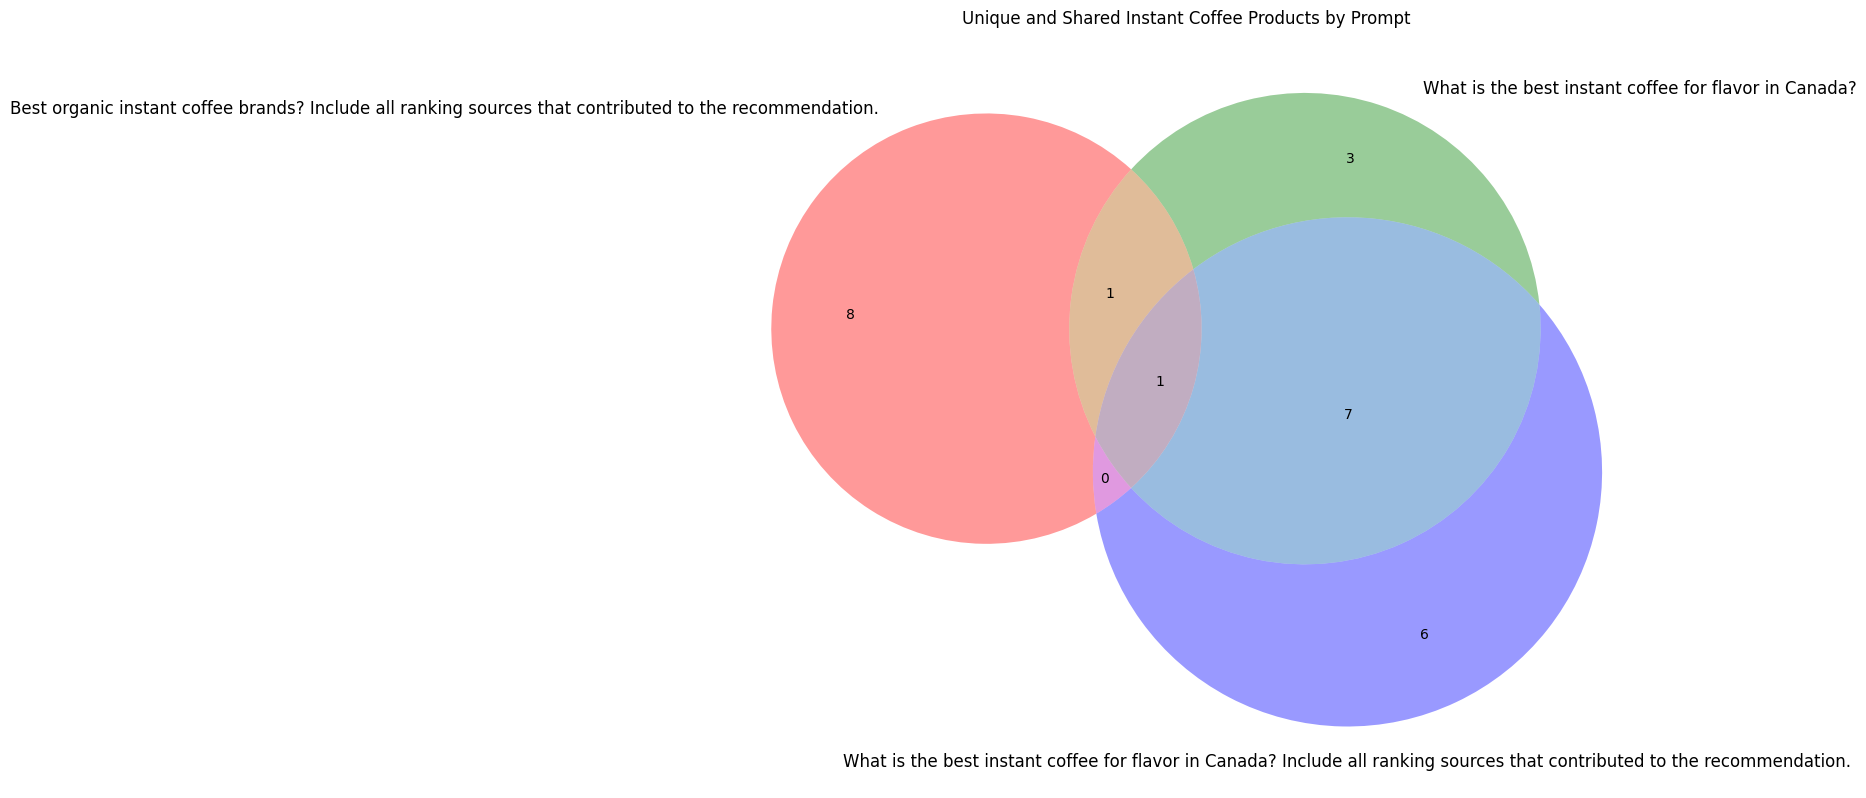

In [41]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Prepare sets for Venn diagram
set1 = unique_sets[prompt_list[0]]
set2 = unique_sets[prompt_list[1]]
set3 = unique_sets[prompt_list[2]]

# Generate Venn diagram
plt.figure(figsize=(16, 10))
venn3([set1, set2, set3], set_labels=prompt_list)
plt.title("Unique and Shared Instant Coffee Products by Prompt")
plt.tight_layout()
plt.show()


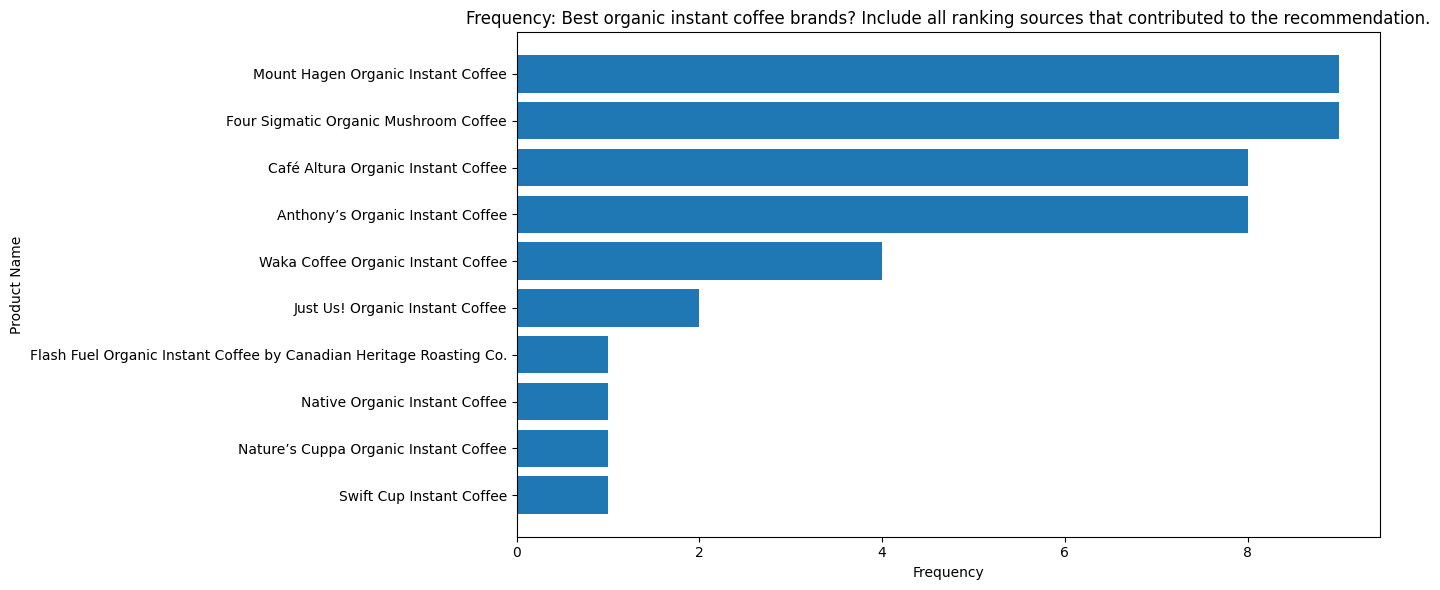

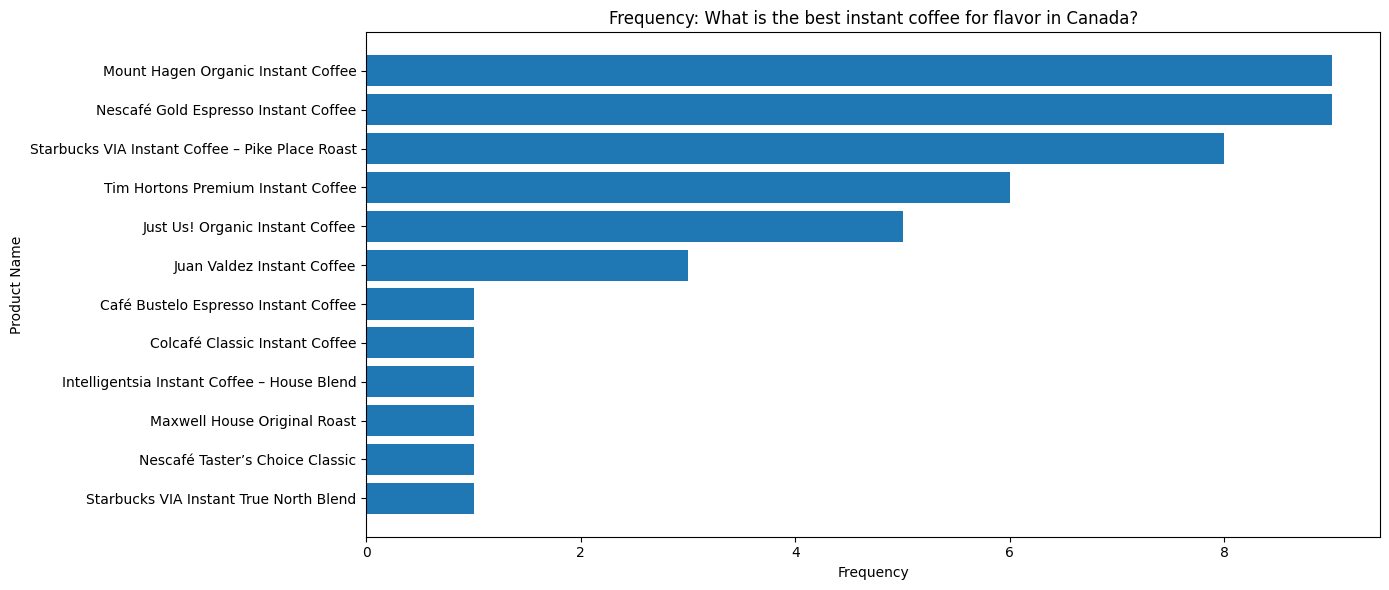

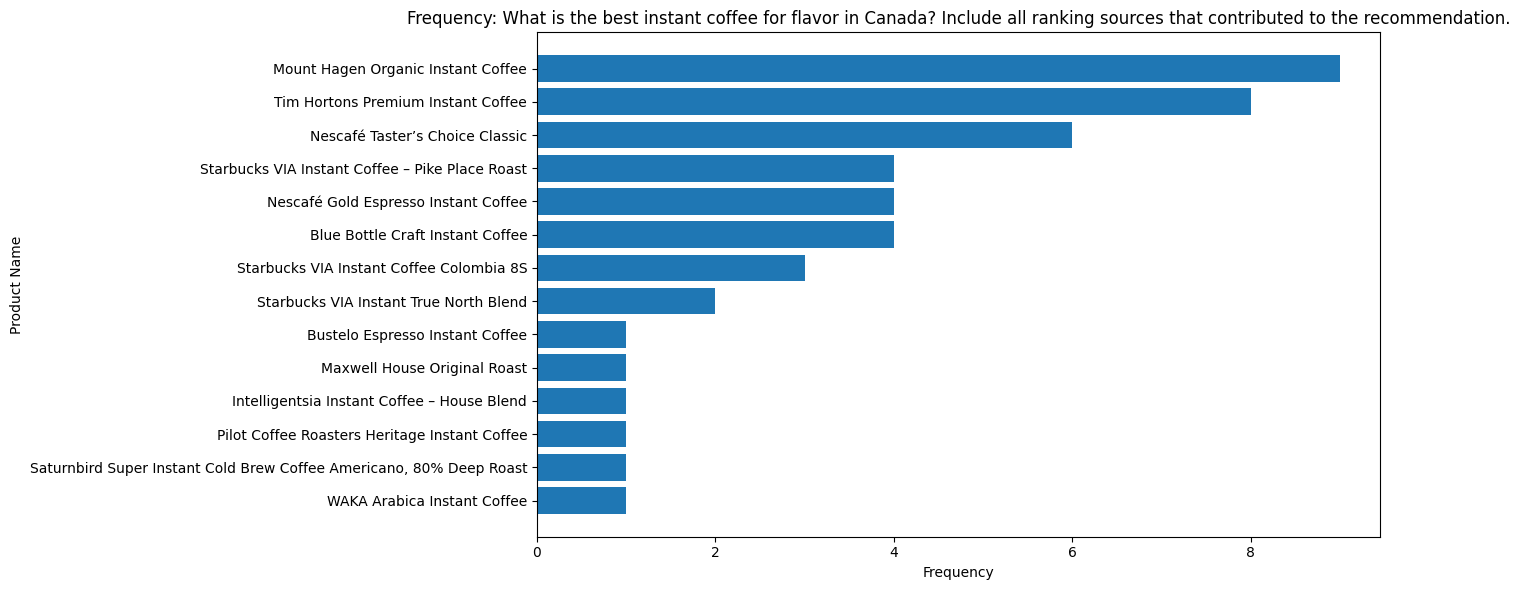

In [39]:
import matplotlib.pyplot as plt

# Group by Prompt and Product Name to get frequency
product_freq_by_prompt = df.groupby(['Prompt', 'Product Name']).size().reset_index(name='Frequency')

# Plot bar charts for each prompt
prompts = product_freq_by_prompt['Prompt'].unique()

# Plot each prompt's product frequencies
for prompt in prompts:
    subset = product_freq_by_prompt[product_freq_by_prompt['Prompt'] == prompt]
    subset_sorted = subset.sort_values(by='Frequency', ascending=False)
    
    plt.figure(figsize=(14, 6))
    plt.barh(subset_sorted['Product Name'], subset_sorted['Frequency'])
    plt.xlabel('Frequency')
    plt.ylabel('Product Name')
    plt.title(f'Frequency: {prompt}')
    plt.gca().invert_yaxis()  # Highest frequency on top
    plt.tight_layout()
    plt.show()


In [19]:
# Combine all URL columns into a single Series
all_urls = pd.concat([df[col].dropna() for col in url_columns])

# Extract domain from each URL
def extract_domain(url):
    try:
        return urlparse(url).netloc
    except:
        return "invalid"

# Count domain frequencies
source_domains = all_urls.dropna().apply(extract_domain)
domain_frequencies = source_domains.value_counts().reset_index()
domain_frequencies.columns = ['Source Domain', 'Frequency']

domain_frequencies.head(10)


,Source Domain,Frequency
0,cornercoffeestore.com,22
1,vincent-michael.com,21
2,www.thespruceeats.com,15
3,www.allrecipes.com,13
4,www.narcity.com,12
5,www.bonappetit.com,12
6,thecoffeeguru.net,9
7,www.reddit.com,7
8,justuscoffee.com,6
9,www.delish.com,6
